MECHANISM OF ACTION PREDICTION

# Loading Dataset and installing packages

## 1. Unzipping files into directory '../dataset'

In [1]:
import zipfile
import os

out_dir = 'dataset'

The zip files are downloaded directly from the kaggle site. 
The output tables are stored in folder './dataset'

In [ ]:
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

def unzip_data(filename):
    with zipfile.ZipFile(filename, 'r') as zf:
        zf.extractall(out_dir)

filename = ['train_features.csv.zip', 'test_features.csv.zip', 'train_targets_scored.csv.zip', 'train_targets_nonscored.csv.zip']

for f in filename:
    unzip_data(f)

## 2. Loading important packages

In [2]:
!pip install category_encoders scikit-multilearn iterative-stratification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# In order to explore the label relations using network graph, following packages are required to be uninstalled and reinstalled
# NOTE: It is requried to restart the runtime

!pip uninstall networkx
!pip uninstall python-louvain
!pip uninstall community
!pip install python-louvain
!pip install networkx


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce


In [28]:
train_features = pd.read_csv(out_dir + '/train_features.csv')
test_features = pd.read_csv(out_dir + '/test_features.csv')
train_targets_scored = pd.read_csv(out_dir + '/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv(out_dir + '/train_targets_nonscored.csv')
train_drug = pd.read_csv(out_dir + '/train_drug.csv')


# UNDERTSTANDING THE DATA

## 1. Training Data

In [42]:
train_features.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3  4.0620 -0.8095  ... -2.0990 -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4  1.4180 -0.8244  ...  0.0042  0.0048  0.6670  1.0690  0.5523 -0.3031   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077  0.7371  
2 -0.6417 -0.2187 -1.4080  0.6931  
3 -1.6210 -0.8784 -0.3876 -0.8154  
4  0.1094  0.2885 -0.3786  0.7125  

[5 rows x 876 columns]

In [43]:
train_features.describe()

cp_time           g-0           g-1           g-2           g-3  \
count  23814.000000  23814.000000  23814.000000  23814.000000  23814.000000   
mean      48.020156      0.248366     -0.095684      0.152253      0.081971   
std       19.402807      1.393399      0.812363      1.035731      0.950012   
min       24.000000     -5.513000     -5.737000     -9.104000     -5.998000   
25%       24.000000     -0.473075     -0.562200     -0.437750     -0.429575   
50%       48.000000     -0.008850     -0.046600      0.075200      0.008050   
75%       72.000000      0.525700      0.403075      0.663925      0.463400   
max       72.000000     10.000000      5.039000      8.257000     10.000000   

                g-4           g-5           g-6           g-7           g-8  \
count  23814.000000  23814.000000  23814.000000  23814.000000  23814.000000   
mean       0.057347     -0.138836      0.035961     -0.202651     -0.190083   
std        1.032091      1.179388      0.882395      1.125494      1.749885   
min       -6.369000    -10.000000    -10.000000    -10.000000    -10.000000   
25%       -0.470925     -0.602225     -0.493900     -0.525175     -0.511675   
50%       -0.026900     -0.015650     -0.000650     -0.017900      0.010000   
75%        0.465375      0.510425      0.528725      0.411900      0.549225   
max       10.000000      7.282000      7.333000      5.473000      8.887000   

       ...          c-90          c-91          c-92          c-93  \
count  ...  23814.000000  23814.000000  23814.000000  23814.000000   
mean   ...     -0.469244     -0.461411     -0.513256     -0.500142   
std    ...      2.000488      2.042475      2.001714      2.107105   
min    ...    -10.000000    -10.000000    -10.000000    -10.000000   
25%    ...     -0.566175     -0.565975     -0.589975     -0.568700   
50%    ...     -0.009900      0.003250     -0.009100     -0.013750   
75%    ...      0.457750      0.461500      0.445675      0.452900   
max    ...      4.069000      3.960000      3.927000      3.596000   

               c-94          c-95          c-96          c-97          c-98  \
count  23814.000000  23814.000000  23814.000000  23814.000000  23814.000000   
mean      -0.507093     -0.353726     -0.463485     -0.378241     -0.470252   
std        2.159589      1.629291      2.059725      1.703615      1.834828   
min      -10.000000    -10.000000    -10.000000    -10.000000    -10.000000   
25%       -0.563775     -0.567975     -0.552575     -0.561000     -0.592600   
50%       -0.003300     -0.010250     -0.001250     -0.006800      0.014000   
75%        0.470900      0.444750      0.465225      0.446400      0.461275   
max        3.747000      2.814000      3.505000      2.924000      3.111000   

               c-99  
count  23814.000000  
mean      -0.301505  
std        1.407918  
min      -10.000000  
25%       -0.562900  
50%       -0.019500  
75%        0.438650  
max        3.805000  

[8 rows x 873 columns]

In [38]:
if train_targets_scored.isnull().any().any():
    print("There are missing values in the DataFrame.")
else:
    print("There are no missing values in the DataFrame.")


There are no missing values in the DataFrame.


In [5]:
DRUG_ID = train_features.filter(regex='^sig')
CP_DATA = train_features.filter(regex='^cp_')
GENE_DATA = train_features.filter(regex='^g-')
CELL_DATA = train_features.filter(regex='^c-')

assert(DRUG_ID.shape[1] + CP_DATA.shape[1] + GENE_DATA.shape[1] + CELL_DATA.shape[1] == train_features.shape[1])

The training data has essentially two large sub categories:
  Gene Expression
  Cell Viablity
The other three features appears to be categorial.

### A. Categorial Data

21948
1866


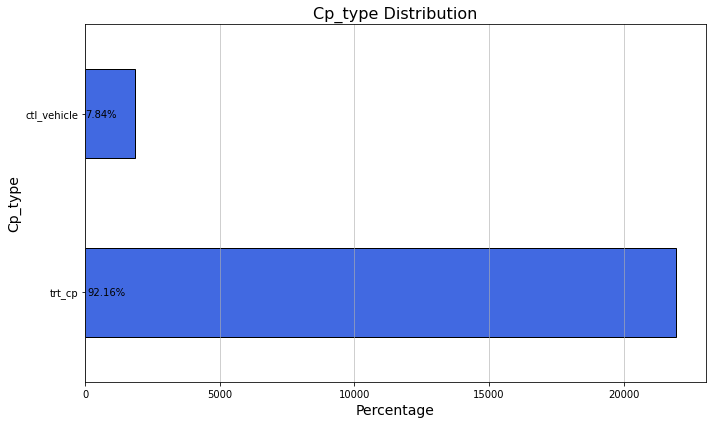

8250
7792
7772


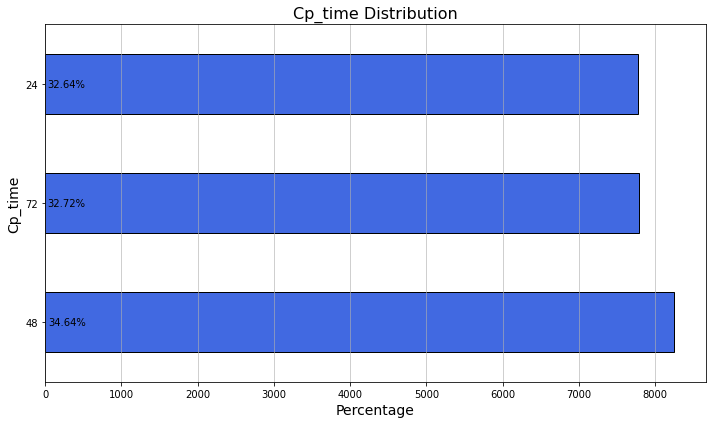

12147
11667


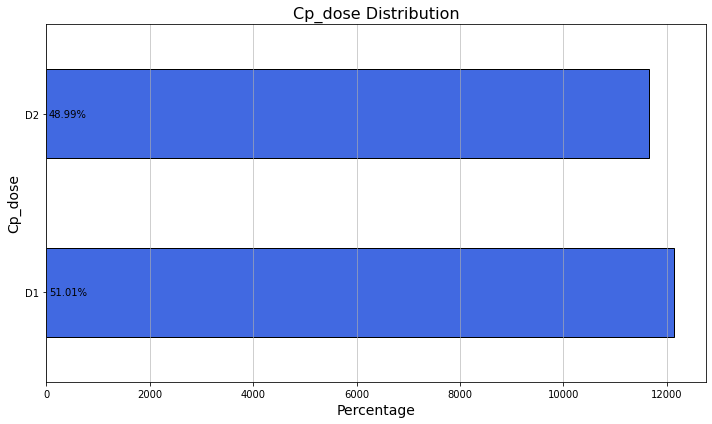

In [6]:
cp_columns = CP_DATA.columns

def plot_categorical_data(dataframe, column_name):

    plt.figure(figsize=(10,6))

    # Create a bar plot for the specified column
    counts = dataframe[column_name].value_counts()
    ax = counts.plot(kind='barh', color='royalblue', edgecolor='black')

    # Customize the plot appearance
    ax.set_title(f'{column_name.capitalize()} Distribution', fontsize=16)
    ax.set_xlabel('Percentage', fontsize=14)
    ax.set_ylabel(column_name.capitalize(), fontsize=14)
    ax.grid(axis='x', alpha=0.75)

    # Add percentage labels next to the bars
    total = counts.sum()
    percentages = counts / total * 100
    for i, value in enumerate(percentages):
        print(counts.iloc[i])
        ax.text(value + 1.0, i, f'{value:.2f}%', va='center', fontsize=10)

    # Show the plot
    plt.tight_layout()
    plt.show()

for col in cp_columns:
    plot_categorical_data(CP_DATA, col)



Processing CP data.
1. Drop 'cp_type' column: imbalance in the training dataset
2. Binary encoding 'cp_time' and 'cp_dose'

In [7]:
def transform_cp_data(df):
    df_copy = df.copy()

    df_copy = df_copy.drop('cp_type', axis=1)
    encoder = ce.BinaryEncoder(cols=['cp_time', 'cp_dose'])
    encoded_dataframe = encoder.fit_transform(df_copy)

    return encoded_dataframe

CP_DATA_encoded = transform_cp_data(CP_DATA)
CP_DATA_encoded.head(5)

cp_time_0  cp_time_1  cp_dose_0  cp_dose_1
0          0          1          0          1
1          1          0          0          1
2          1          1          0          1
3          1          1          0          1
4          1          0          1          0

Some Functions for plotting and analysis

In [80]:
def kde_plots(df, num_plots=50, figsize=(25, 25)):
  # given a dataframe df, plot kernel density estimator plots for all its features

  fig, axes = plt.subplots(int(num_plots/5), 5, figsize=figsize)
  axes = axes.ravel()

  for i in range(num_plots):
      column = df.columns[i]
      sns.kdeplot(data=df, x=column, ax=axes[i], fill=True, alpha=0.5, linewidth=1.5)
      axes[i].set_title(f'KDE of {column}', fontsize=10)

  plt.subplots_adjust(hspace=0.5, wspace=0.5)
  plt.tight_layout()
  plt.show()
  plt.close()


In [81]:
def get_corr(df, plot=False):
  # Given a dataframe df, returns correlation matrix for all features in the dataframe

  corr_matrix = df.corr()
  if plot:
    fig = plt.figure(figsize=(36,36),alpha=0.75)
    sns.heatmap(corr_matrix, fmt = '.2f')

  return corr_matrix

In [82]:
def high_correlations(df, corr_matrix, threshold=0.8):
  # Given a dataframe df, return highly correlated feature pairs 
  # with correlation above a threshold

  threshold = threshold
  highly_correlated_columns = []
  corr_val = []

  # Find pairs of high correlation above the defined threshold
  for i, column_i in enumerate(corr_matrix.columns[:-1]):
      for j, column_j in enumerate(corr_matrix.columns[i + 1:]):
          if abs(corr_matrix.iloc[i, i + j + 1]) >= threshold:
              highly_correlated_columns.append((column_i, column_j))
              corr_val.append(corr_matrix.iloc[i, i + j + 1])

  # Display the pairs of highly correlated columns
  print("Pairs of highly correlated columns:")
  for col_pair, cor_val in zip(highly_correlated_columns, corr_val):
      print(f"{col_pair[0]} and {col_pair[1]} = {cor_val}")
  
  return highly_correlated_columns



### B. Gene Data

In [83]:
GENE_DATA.shape

(23814, 772)

There are 772 values for gene expression for each sample

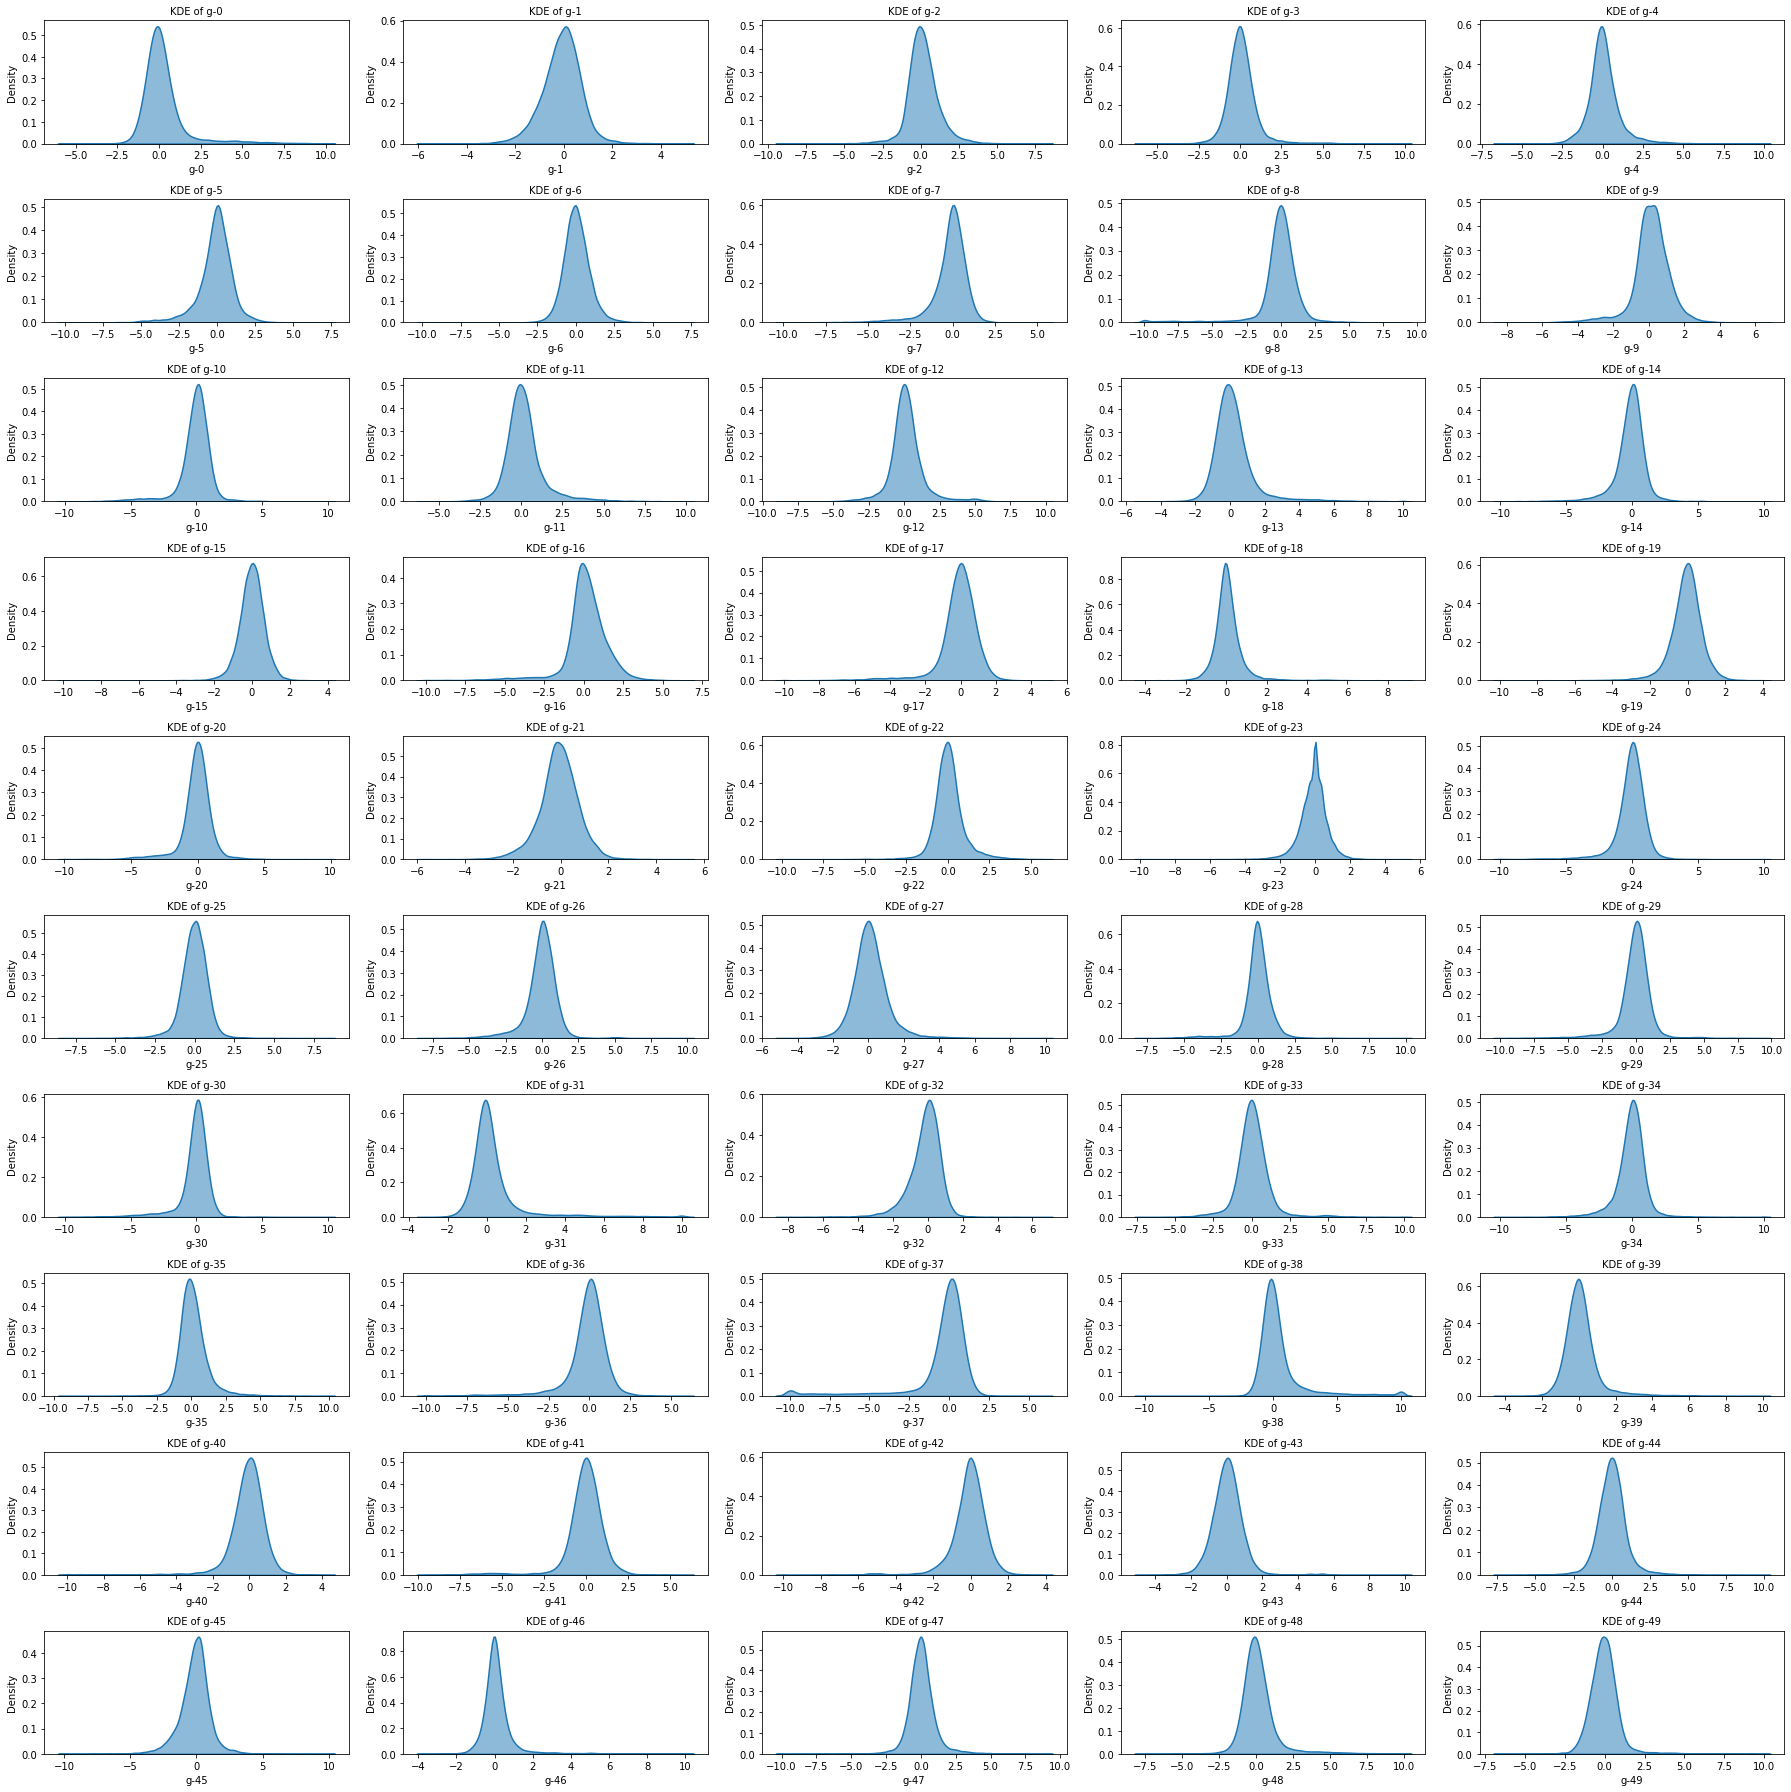

In [84]:
kde_plots(GENE_DATA)

Finding Correlated Genes

<Axes: >

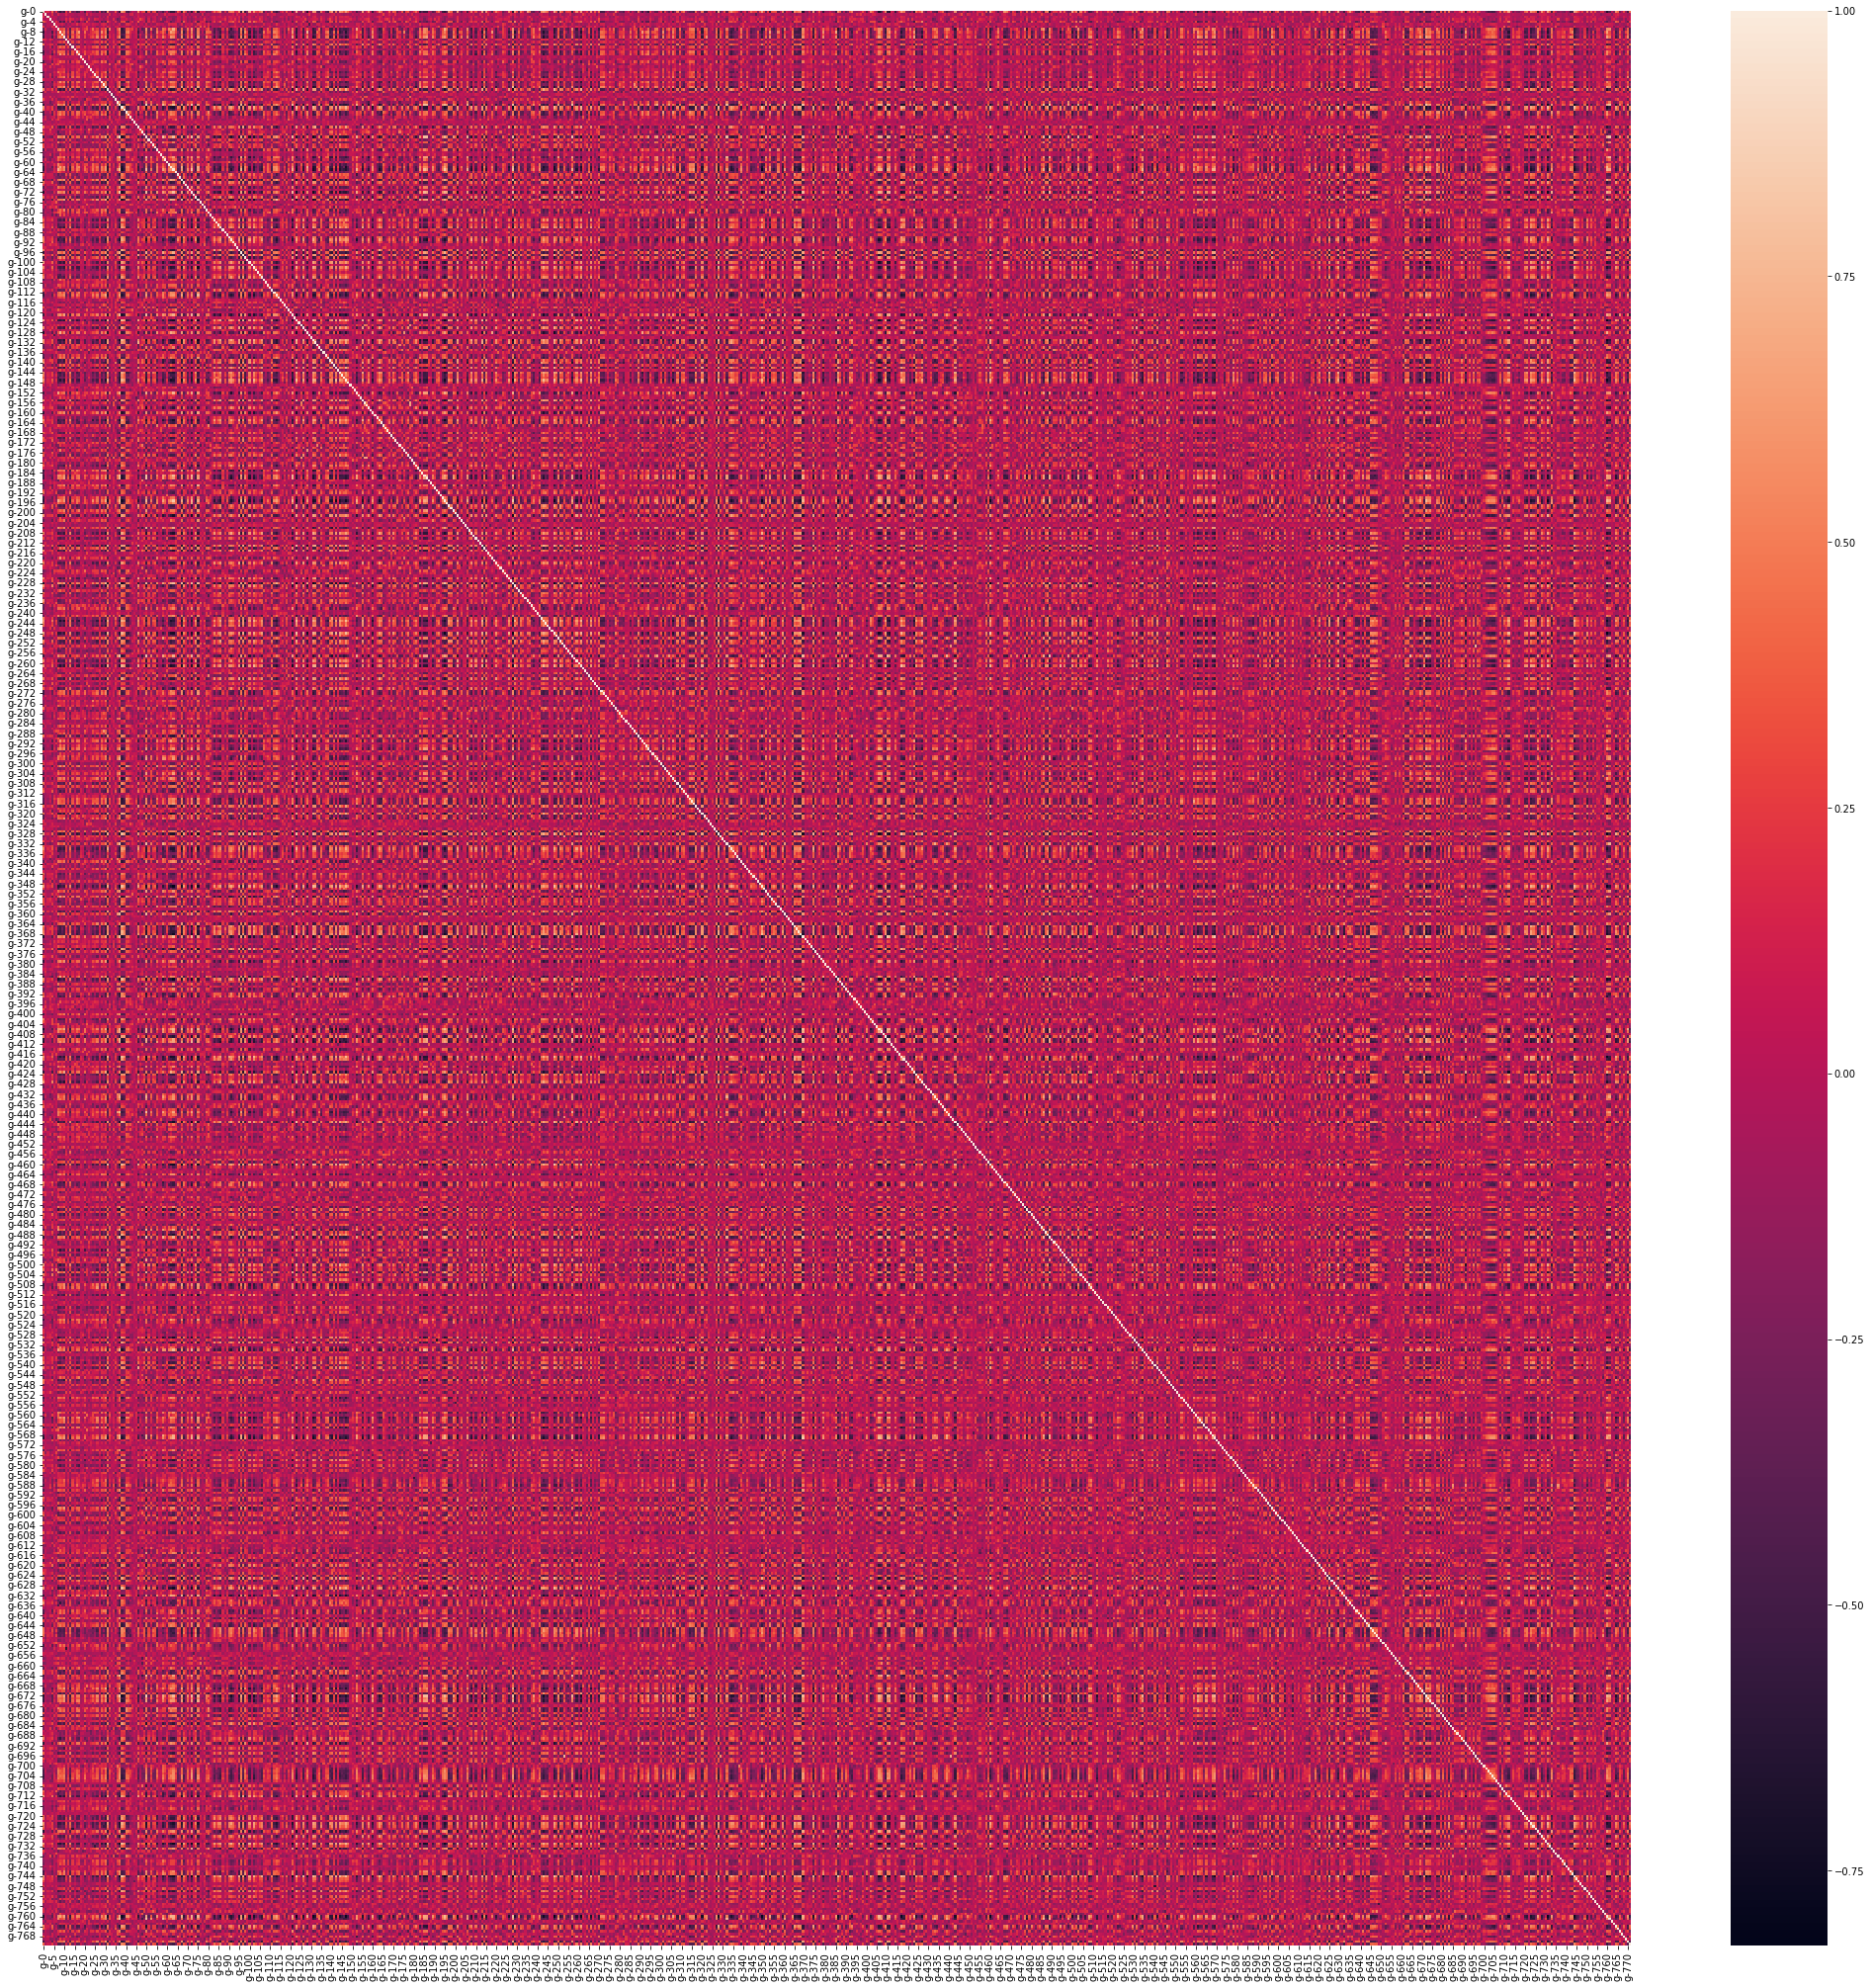

In [85]:
corr_matrix_g = GENE_DATA.corr()
fig = plt.figure(figsize=(36,36),alpha=0.75)
sns.heatmap(corr_matrix_g, fmt = '.2f')


In [86]:
corr_matrix_g = get_corr(GENE_DATA)


In [87]:
correlated_pairs_gene = high_correlations(GENE_DATA, corr_matrix_g)
print(f'Number of highly correlated pairs = {len(correlated_pairs_gene)}')

Pairs of highly correlated columns:
g-37 and g-50 = 0.9070612663690849
g-37 and g-72 = 0.8185552975996002
g-37 and g-489 = 0.8425249963111192
g-37 and g-672 = 0.8236734642586089
g-38 and g-744 = 0.8189881165986562
g-50 and g-257 = 0.8049847665318204
g-50 and g-489 = 0.8404041112557281
g-50 and g-672 = 0.8456681285059011
g-63 and g-195 = 0.8327792012613492
g-63 and g-349 = -0.8062104634994306
g-121 and g-672 = 0.8309266986565694
g-123 and g-460 = 0.8064281502828231
g-123 and g-744 = 0.8331501648248927
g-195 and g-228 = 0.8072094539192923
g-228 and g-349 = -0.8202749561736793
g-228 and g-460 = -0.807640253503909
g-228 and g-744 = -0.8087880774226857
g-248 and g-460 = 0.8213841514459428
g-248 and g-760 = -0.8091367713255653
g-261 and g-417 = 0.8060170734584688
g-328 and g-417 = 0.805924223727605
g-349 and g-460 = 0.8368593496530334
g-369 and g-406 = 0.8048828930093489
g-369 and g-410 = 0.8256458052265652
g-369 and g-569 = 0.8348645137975708
g-460 and g-744 = 0.8019631396160095
Number of h

### C. Cell Data

In [88]:
CELL_DATA.shape

(23814, 100)

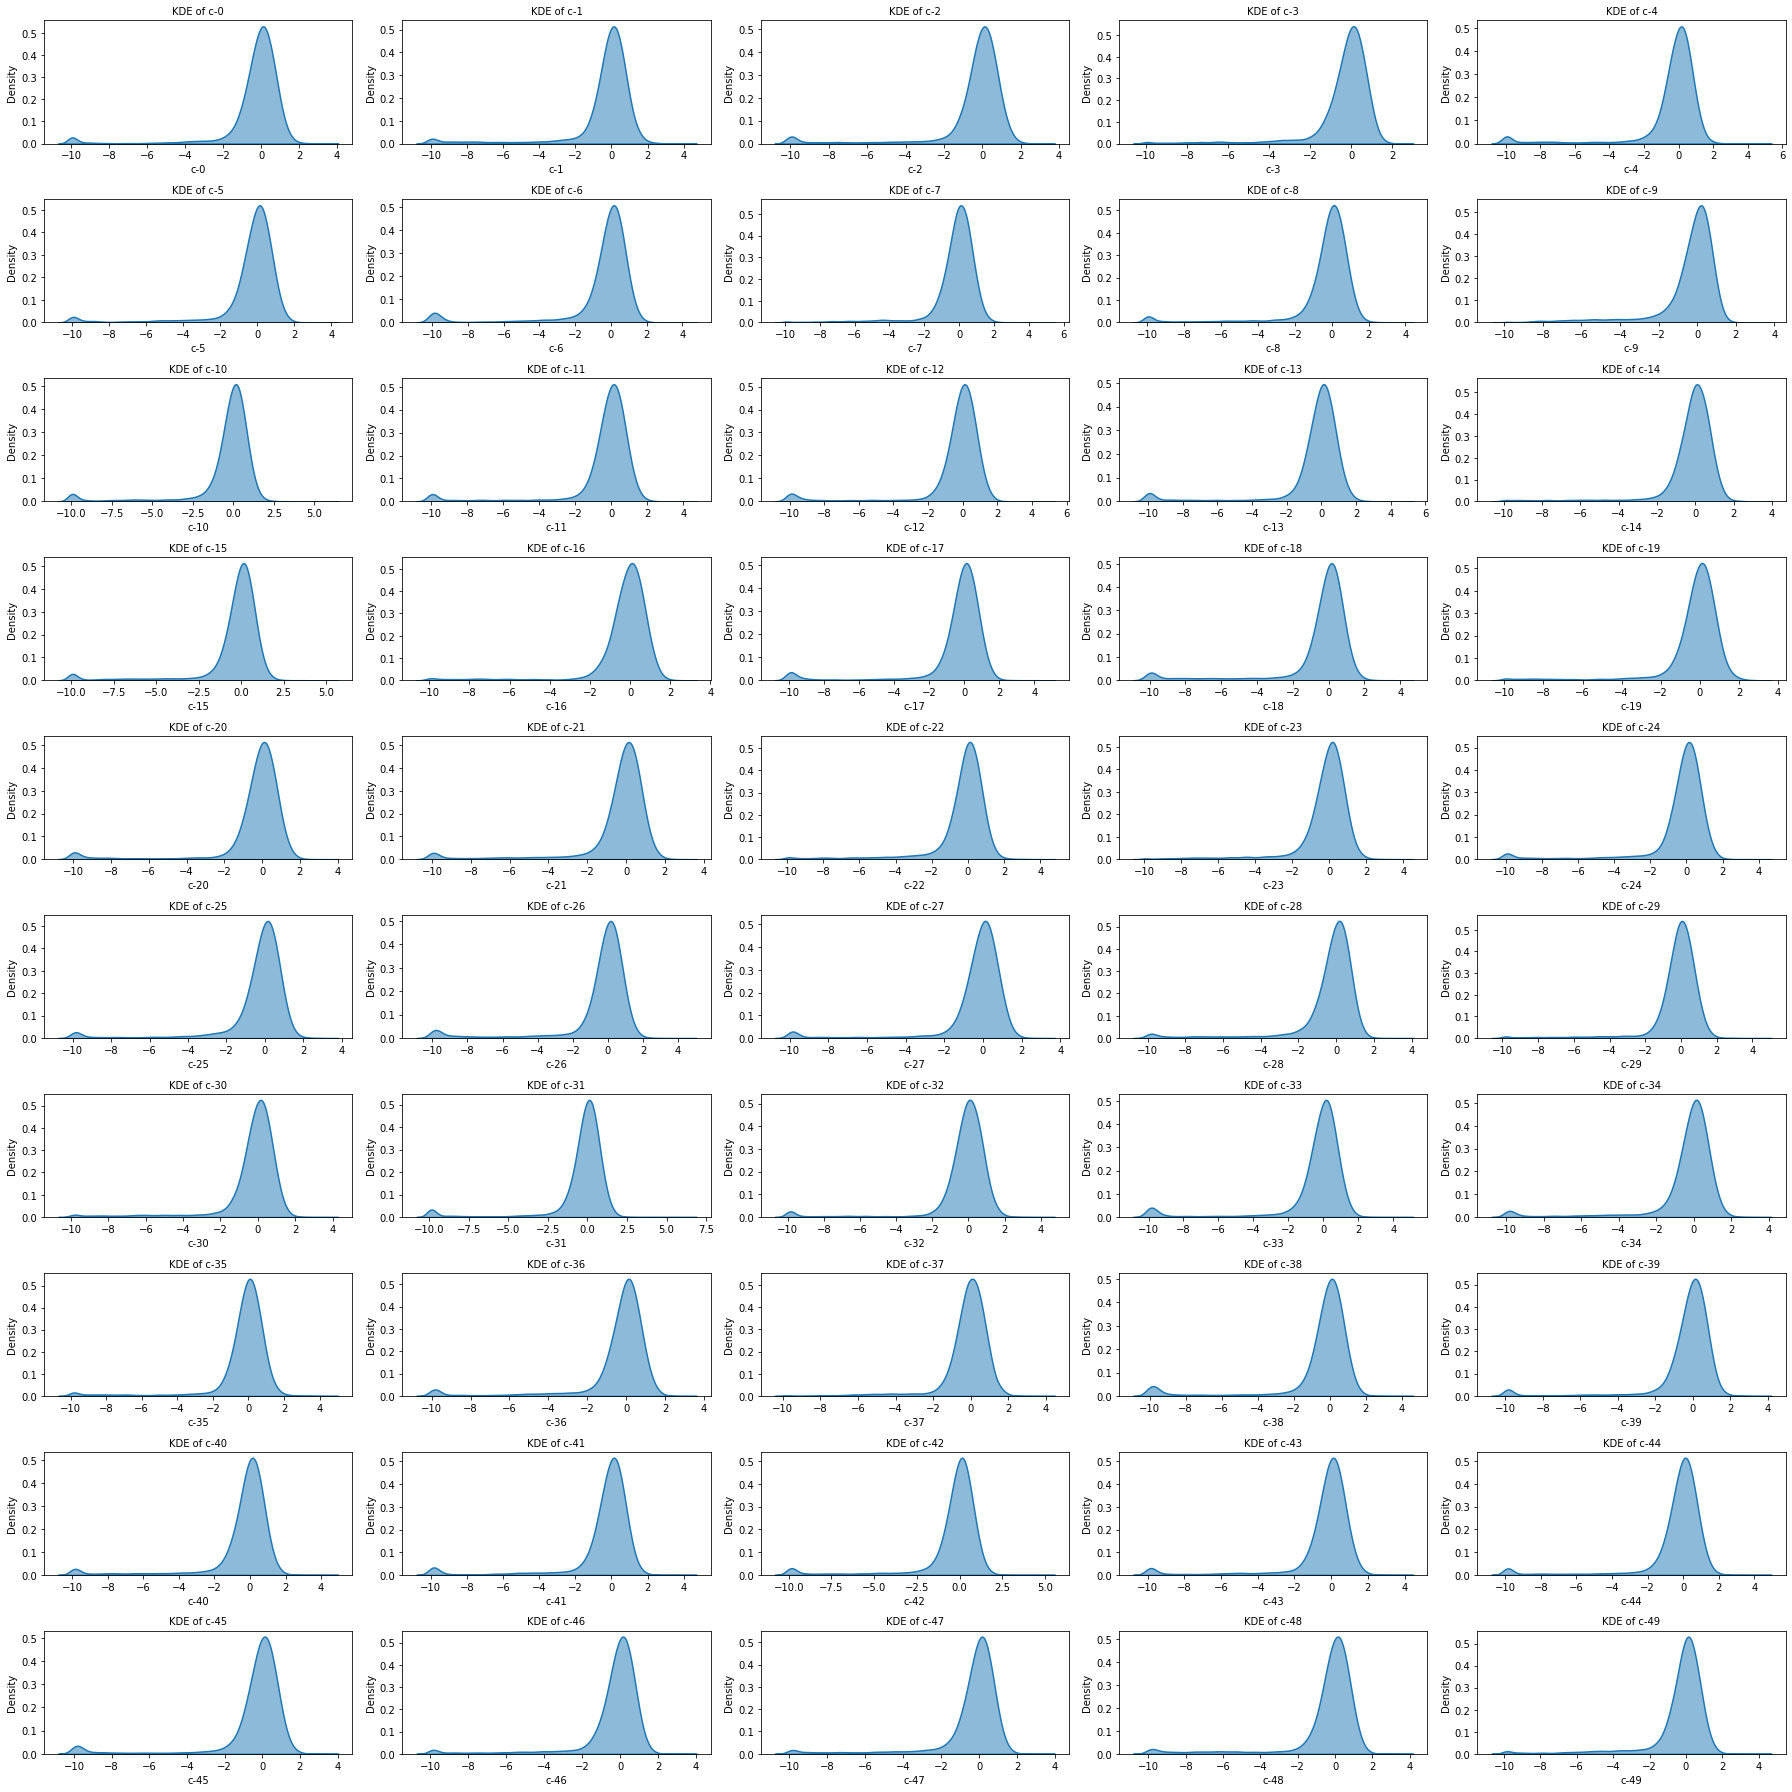

In [89]:
kde_plots(CELL_DATA)

<Axes: >

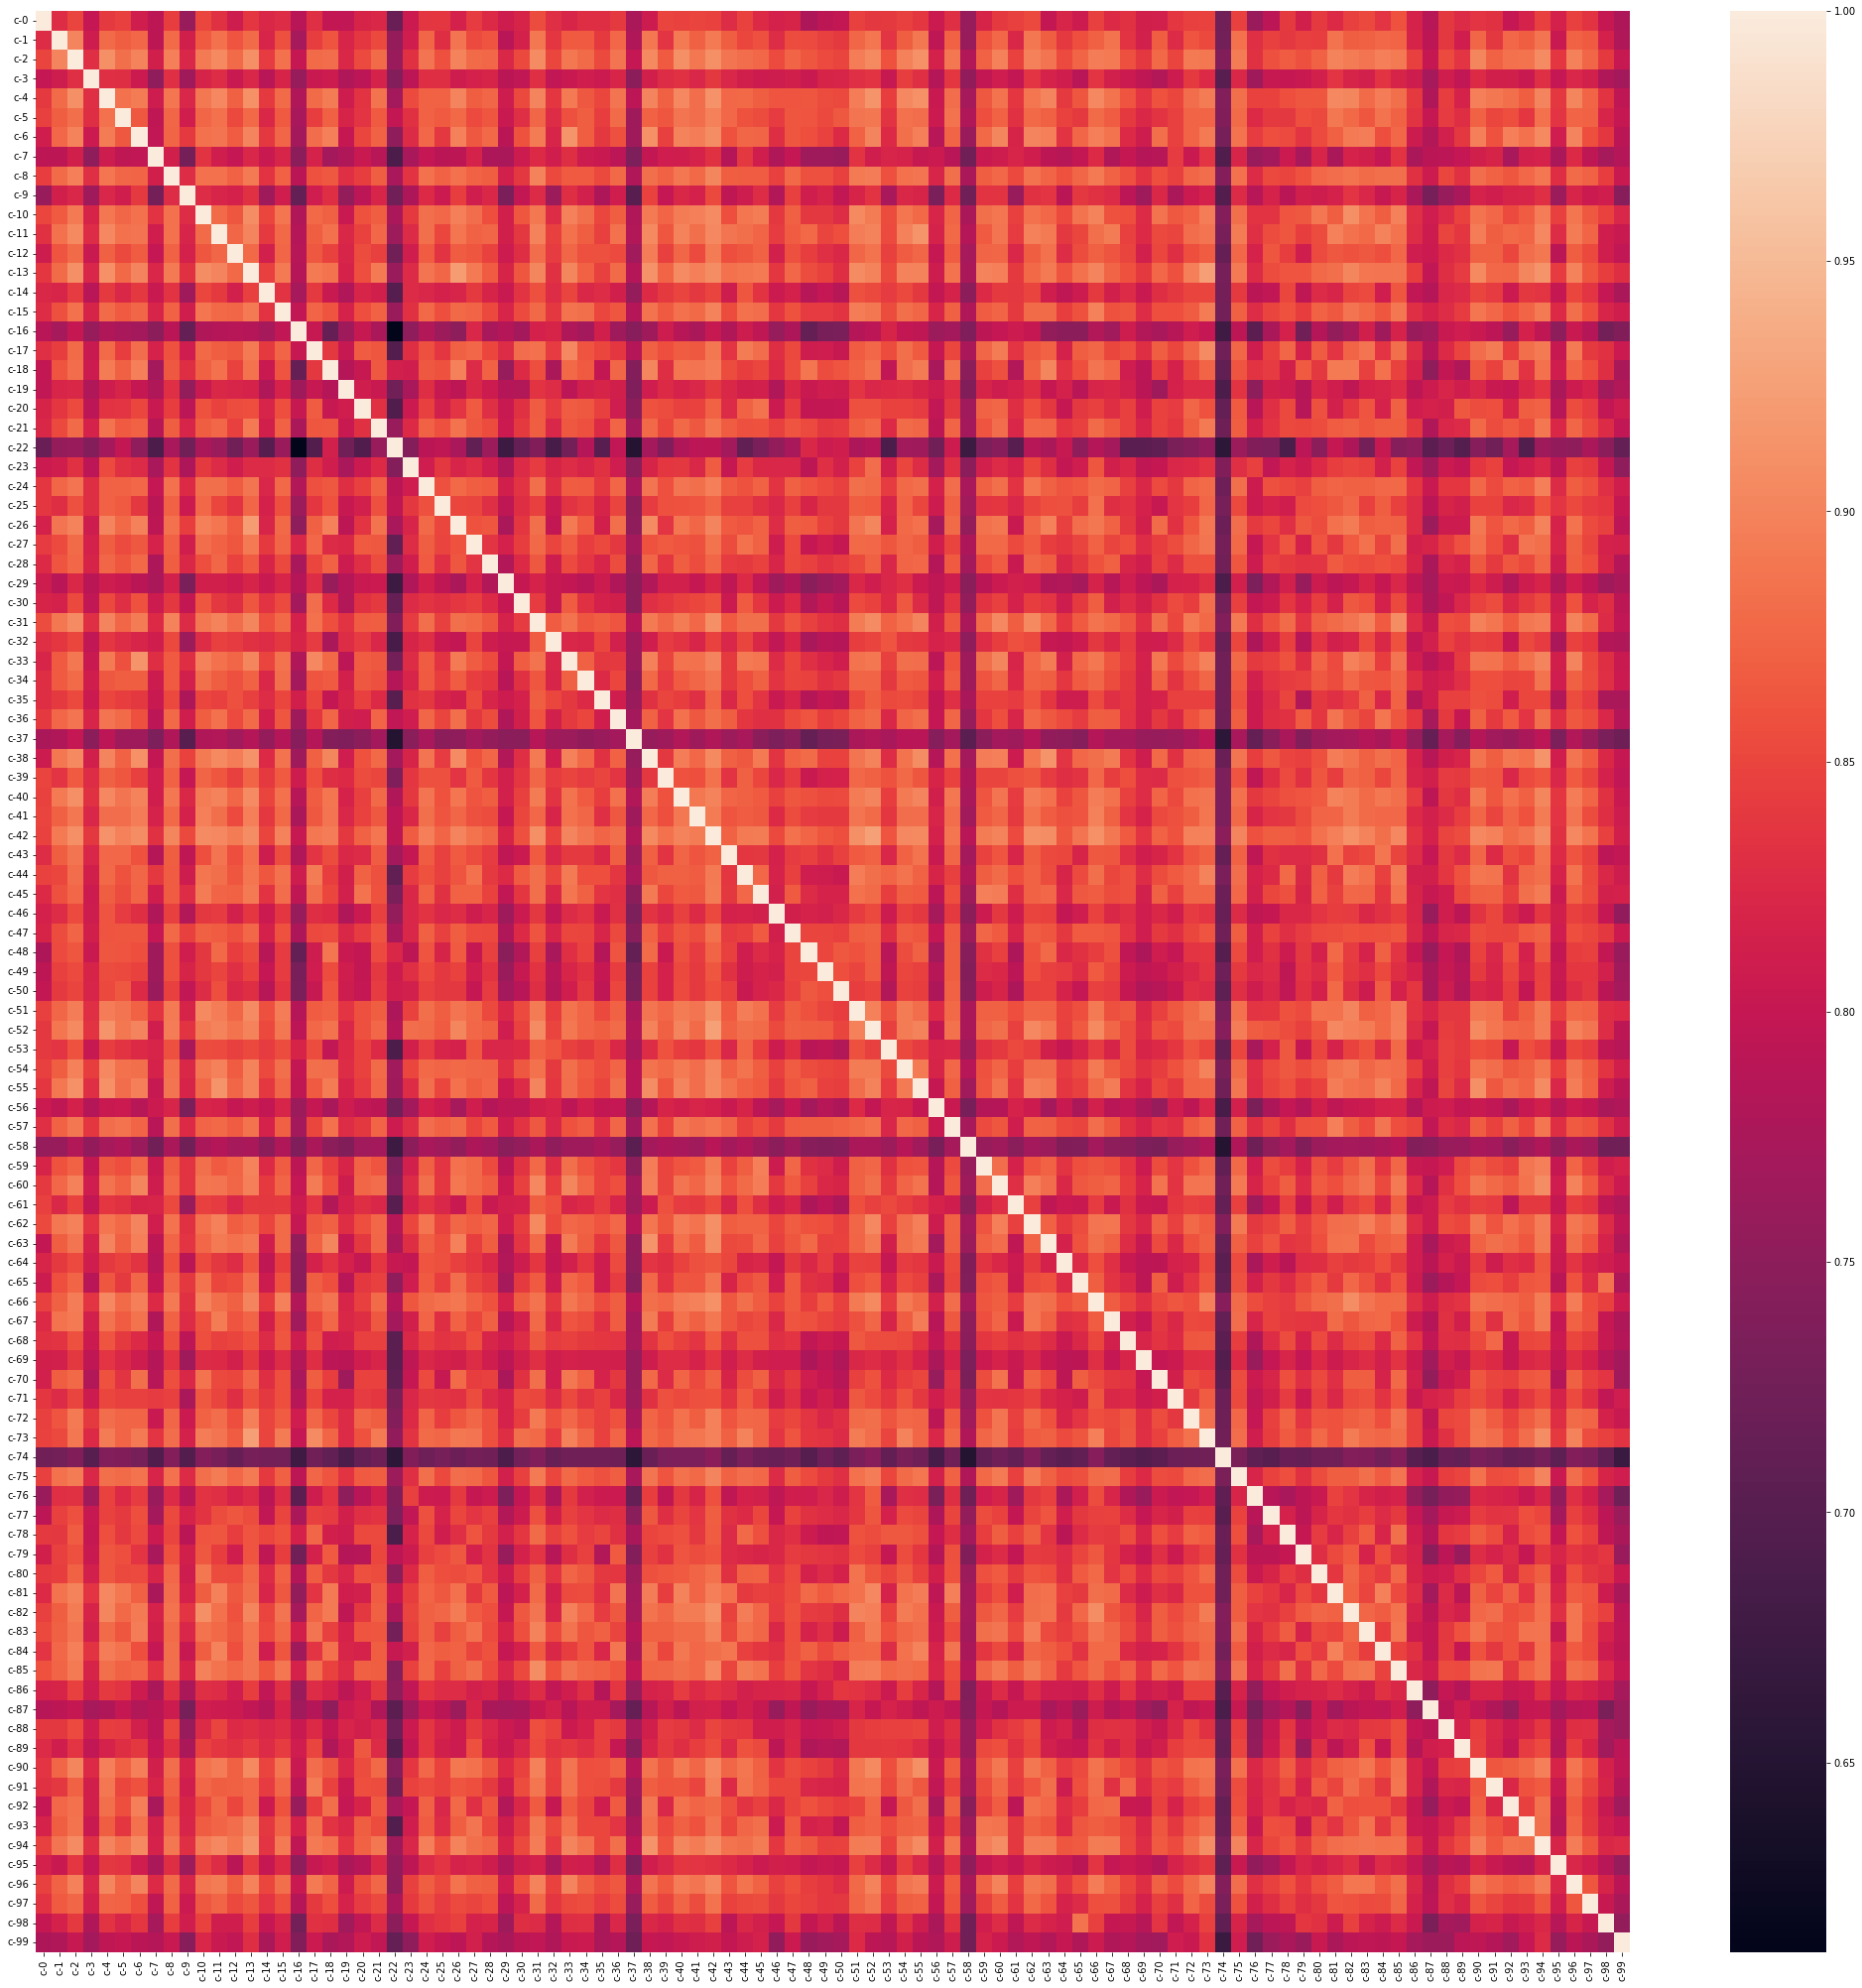

In [90]:
corr_matrix_c = CELL_DATA.corr()
fig = plt.figure(figsize=(36,36),alpha=0.75)
sns.heatmap(corr_matrix_c, fmt = '.2f')


In [91]:
correlated_pairs_cells = high_correlations(CELL_DATA, corr_matrix_c, threshold=0.9)
print(f'Number of highly correlated pairs = {len(correlated_pairs_cells)}')

Pairs of highly correlated columns:
c-1 and c-2 = 0.9014163675823964
c-2 and c-4 = 0.909990829131269
c-2 and c-11 = 0.9049678314240568
c-2 and c-13 = 0.9104973289319644
c-2 and c-31 = 0.9060518850814185
c-2 and c-38 = 0.9054494688884323
c-2 and c-40 = 0.9098287358157184
c-2 and c-42 = 0.9090859310088174
c-2 and c-52 = 0.9056523474314477
c-2 and c-55 = 0.9117868111442688
c-2 and c-90 = 0.9029639219180562
c-2 and c-94 = 0.9065842450248173
c-4 and c-11 = 0.9040815778624942
c-4 and c-13 = 0.9111296090240699
c-4 and c-26 = 0.9000021071665225
c-4 and c-31 = 0.9011485723501689
c-4 and c-38 = 0.900724740263834
c-4 and c-40 = 0.9045278396833618
c-4 and c-42 = 0.9132415143495981
c-4 and c-52 = 0.9136485678478677
c-4 and c-54 = 0.9037512805255474
c-4 and c-55 = 0.9112881397705224
c-4 and c-63 = 0.9004351412421848
c-4 and c-66 = 0.9035552402710861
c-4 and c-81 = 0.9037562481096909
c-4 and c-82 = 0.9026249397665244
c-4 and c-94 = 0.9003093876886781
c-4 and c-96 = 0.9016033949766101
c-6 and c-13 = 0

The cell viablity features much higher percentage of correlated feature pairs than the gene expression features.

These correlated pairs can be used to design new features by either:

>  a. Creating new features by multiplying the feature pairs

> b. Dropping one of the feature in the correlated pair

This comes down to whether other ways of reducing dimensionality are effective or not. 

## 2. Target Labels

In [92]:
train_targets_scored.head()

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  ...  tropomyosin_receptor_kinase_inhibitor  \
0                           0  ...                                      0   
1                           0  ...                                      0   
2                           0  ...                                      0   
3                           0  ...                                      0   
4                           0  ...                                      0   

   trpv_agonist  trpv_antagonist  tubulin_inhibitor  \
0             0                0                  0   
1             0                0                  0   
2             0                0                  0   
3             0                0                  0   
4             0                0                  0   

   tyrosine_kinase_inhibitor  ubiquitin_specific_protease_inhibitor  \
0                          0                                      0   
1                          0                                      0   
2                          0                                      0   
3                          0                                      0   
4                          0                                      0   

   vegfr_inhibitor  vitamin_b  vitamin_d_receptor_agonist  wnt_inhibitor  
0                0          0                           0              0  
1                0          0                           0              0  
2                0          0                           0              0  
3                0          0                           0              0  
4                0          0                           0              0  

[5 rows x 207 columns]

In [96]:
train_targets_scored = train_targets_scored.drop('sig_id', axis=1)

In [93]:
train_targets_scored.describe()

5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  acat_inhibitor  \
count                 23814.000000            23814.000000    23814.000000   
mean                      0.000714                0.000756        0.001008   
std                       0.026709                0.027483        0.031731   
min                       0.000000                0.000000        0.000000   
25%                       0.000000                0.000000        0.000000   
50%                       0.000000                0.000000        0.000000   
75%                       0.000000                0.000000        0.000000   
max                       1.000000                1.000000        1.000000   

       acetylcholine_receptor_agonist  acetylcholine_receptor_antagonist  \
count                    23814.000000                       23814.000000   
mean                         0.007979                           0.012640   
std                          0.088967                           0.111716   
min                          0.000000                           0.000000   
25%                          0.000000                           0.000000   
50%                          0.000000                           0.000000   
75%                          0.000000                           0.000000   
max                          1.000000                           1.000000   

       acetylcholinesterase_inhibitor  adenosine_receptor_agonist  \
count                    23814.000000                23814.000000   
mean                         0.003065                    0.002268   
std                          0.055283                    0.047566   
min                          0.000000                    0.000000   
25%                          0.000000                    0.000000   
50%                          0.000000                    0.000000   
75%                          0.000000                    0.000000   
max                          1.000000                    1.000000   

       adenosine_receptor_antagonist  adenylyl_cyclase_activator  \
count                   23814.000000                23814.000000   
mean                        0.004031                    0.000504   
std                         0.063365                    0.022443   
min                         0.000000                    0.000000   
25%                         0.000000                    0.000000   
50%                         0.000000                    0.000000   
75%                         0.000000                    0.000000   
max                         1.000000                    1.000000   

       adrenergic_receptor_agonist  ...  \
count                 23814.000000  ...   
mean                      0.011338  ...   
std                       0.105876  ...   
min                       0.000000  ...   
25%                       0.000000  ...   
50%                       0.000000  ...   
75%                       0.000000  ...   
max                       1.000000  ...   

       tropomyosin_receptor_kinase_inhibitor  trpv_agonist  trpv_antagonist  \
count                           23814.000000  23814.000000     23814.000000   
mean                                0.000252      0.001050         0.002016   
std                                 0.015871      0.032384         0.044851   
min                                 0.000000      0.000000         0.000000   
25%                                 0.000000      0.000000         0.000000   
50%                                 0.000000      0.000000         0.000000   
75%                                 0.000000      0.000000         0.000000   
max                                 1.000000      1.000000         1.000000   

       tubulin_inhibitor  tyrosine_kinase_inhibitor  \
count       23814.000000               23814.000000   
mean            0.013270                   0.003065   
std             0.114429                   0.055283   
min             0.000000                   0.000000   
25%      

In [94]:
if train_targets_scored.isnull().any().any():
    print("There are missing values in the DataFrame.")
else:
    print("There are no missing values in the DataFrame.")


There are no missing values in the DataFrame.


In [97]:
col_sums = train_targets_scored.sum(axis=0).sort_values(ascending=False)

In [98]:
col_sums[col_sums == 1]

erbb2_inhibitor                               1
atp-sensitive_potassium_channel_antagonist    1
dtype: int64

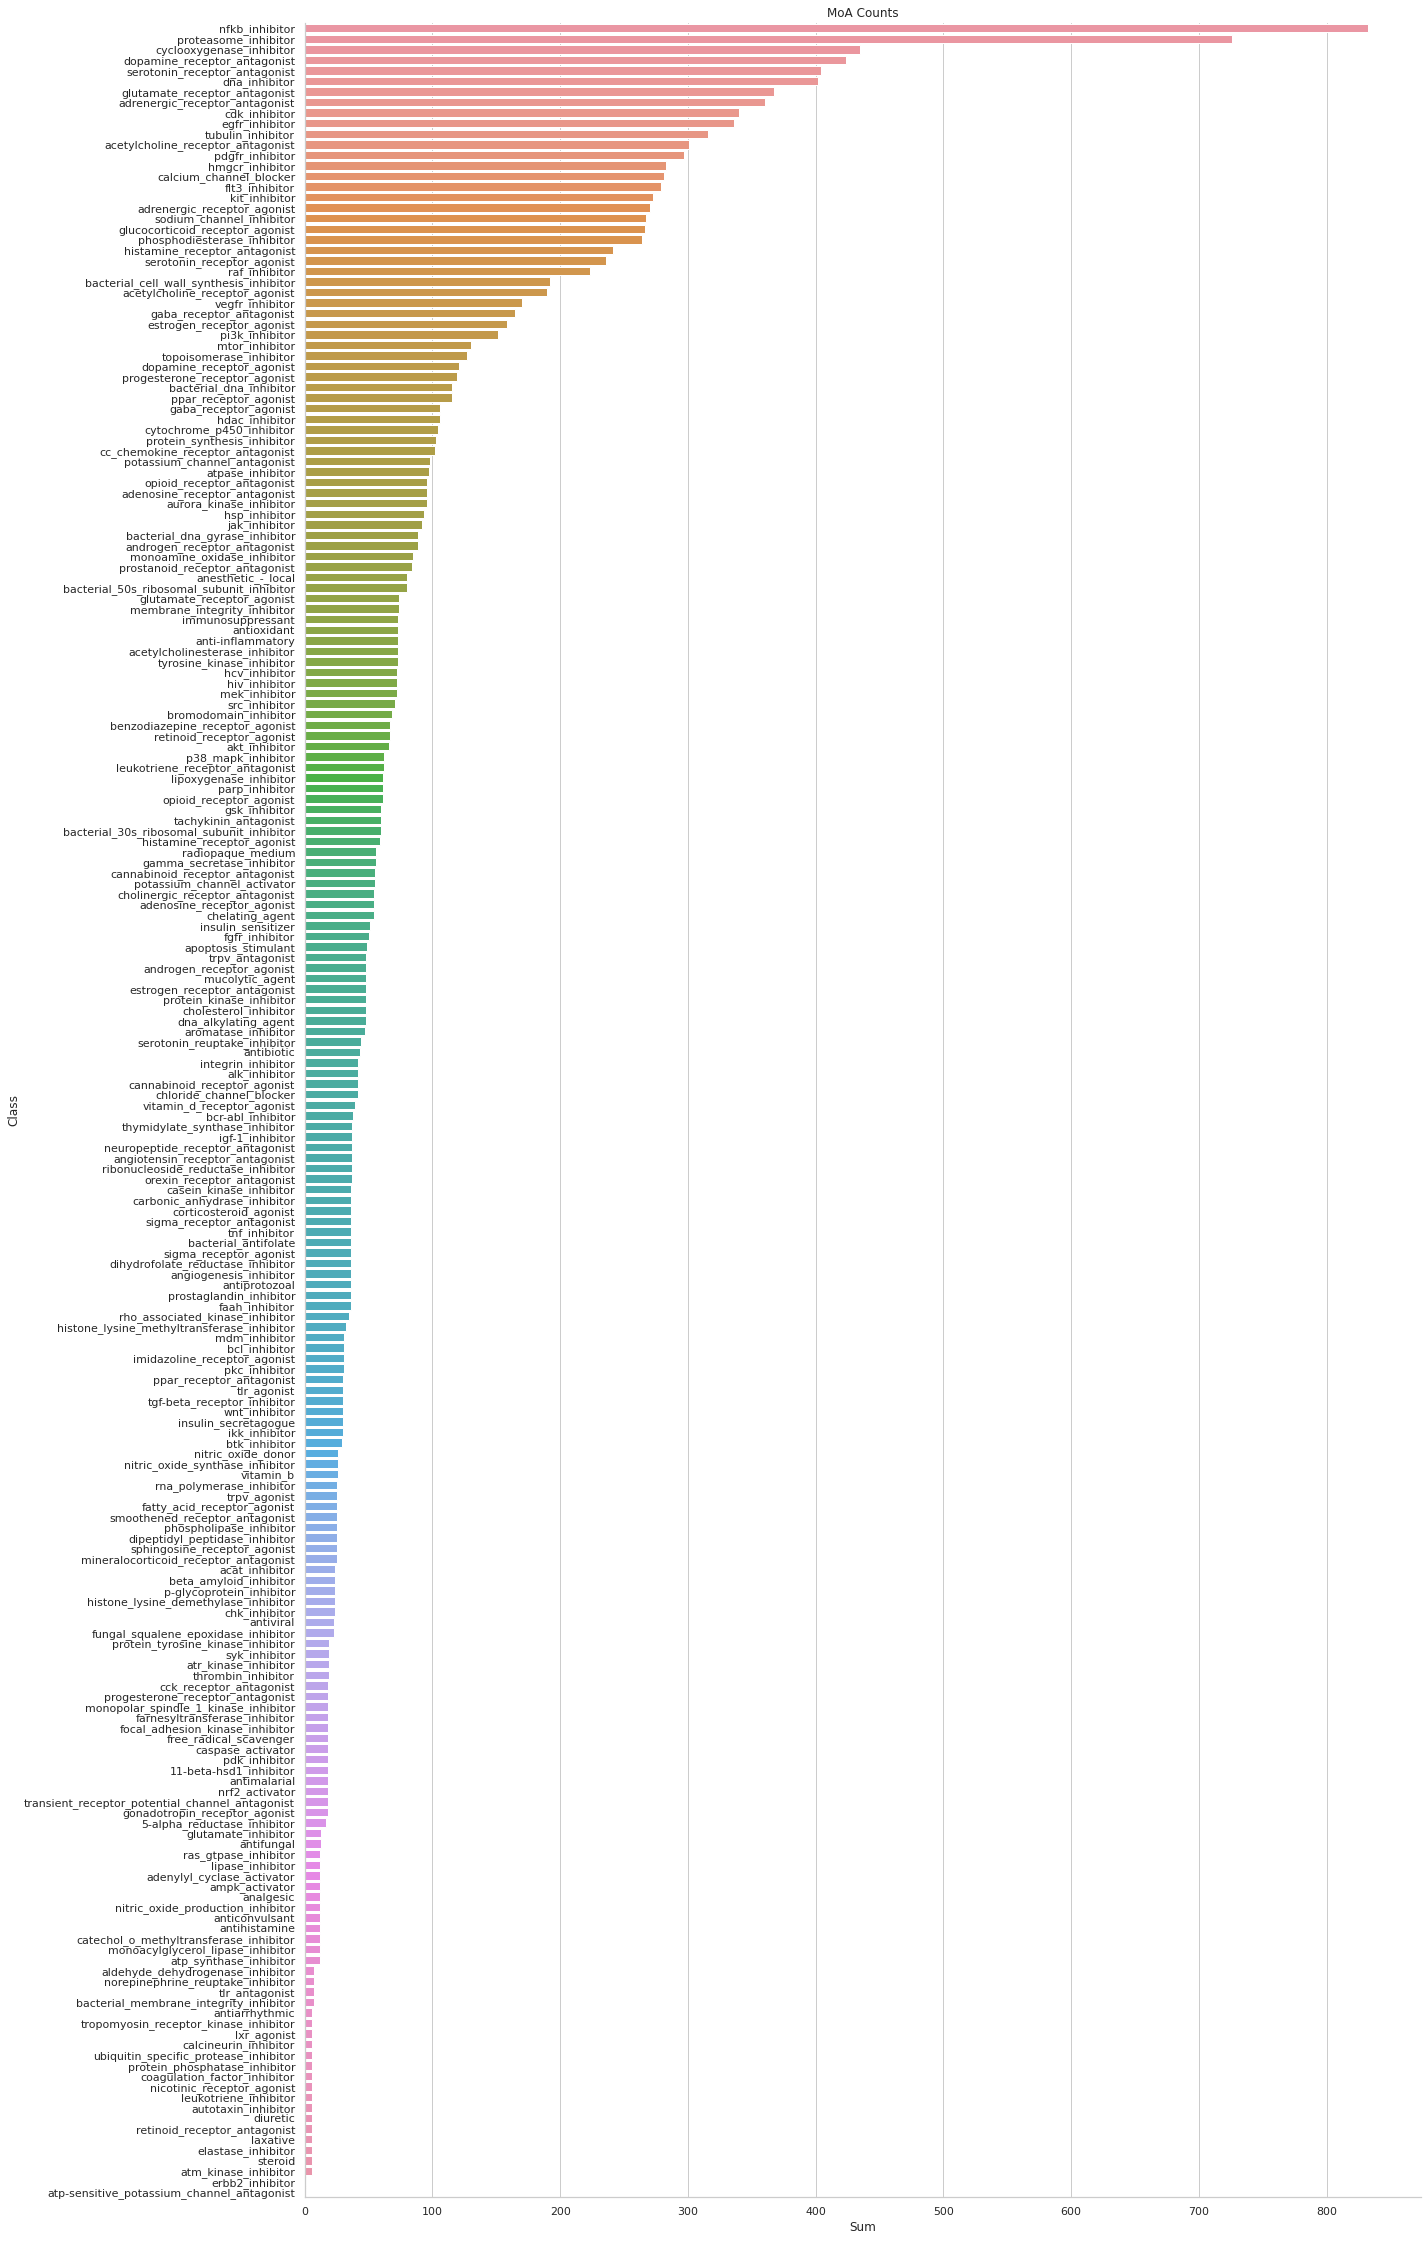

In [99]:
sns.set(style='whitegrid', rc={'figure.figsize':(20,40)})

ax = sns.barplot(x=col_sums, y=col_sums.index)
ax.set(xlabel='Sum', ylabel='Class', title='MoA Counts')
sns.despine()


<Axes: >

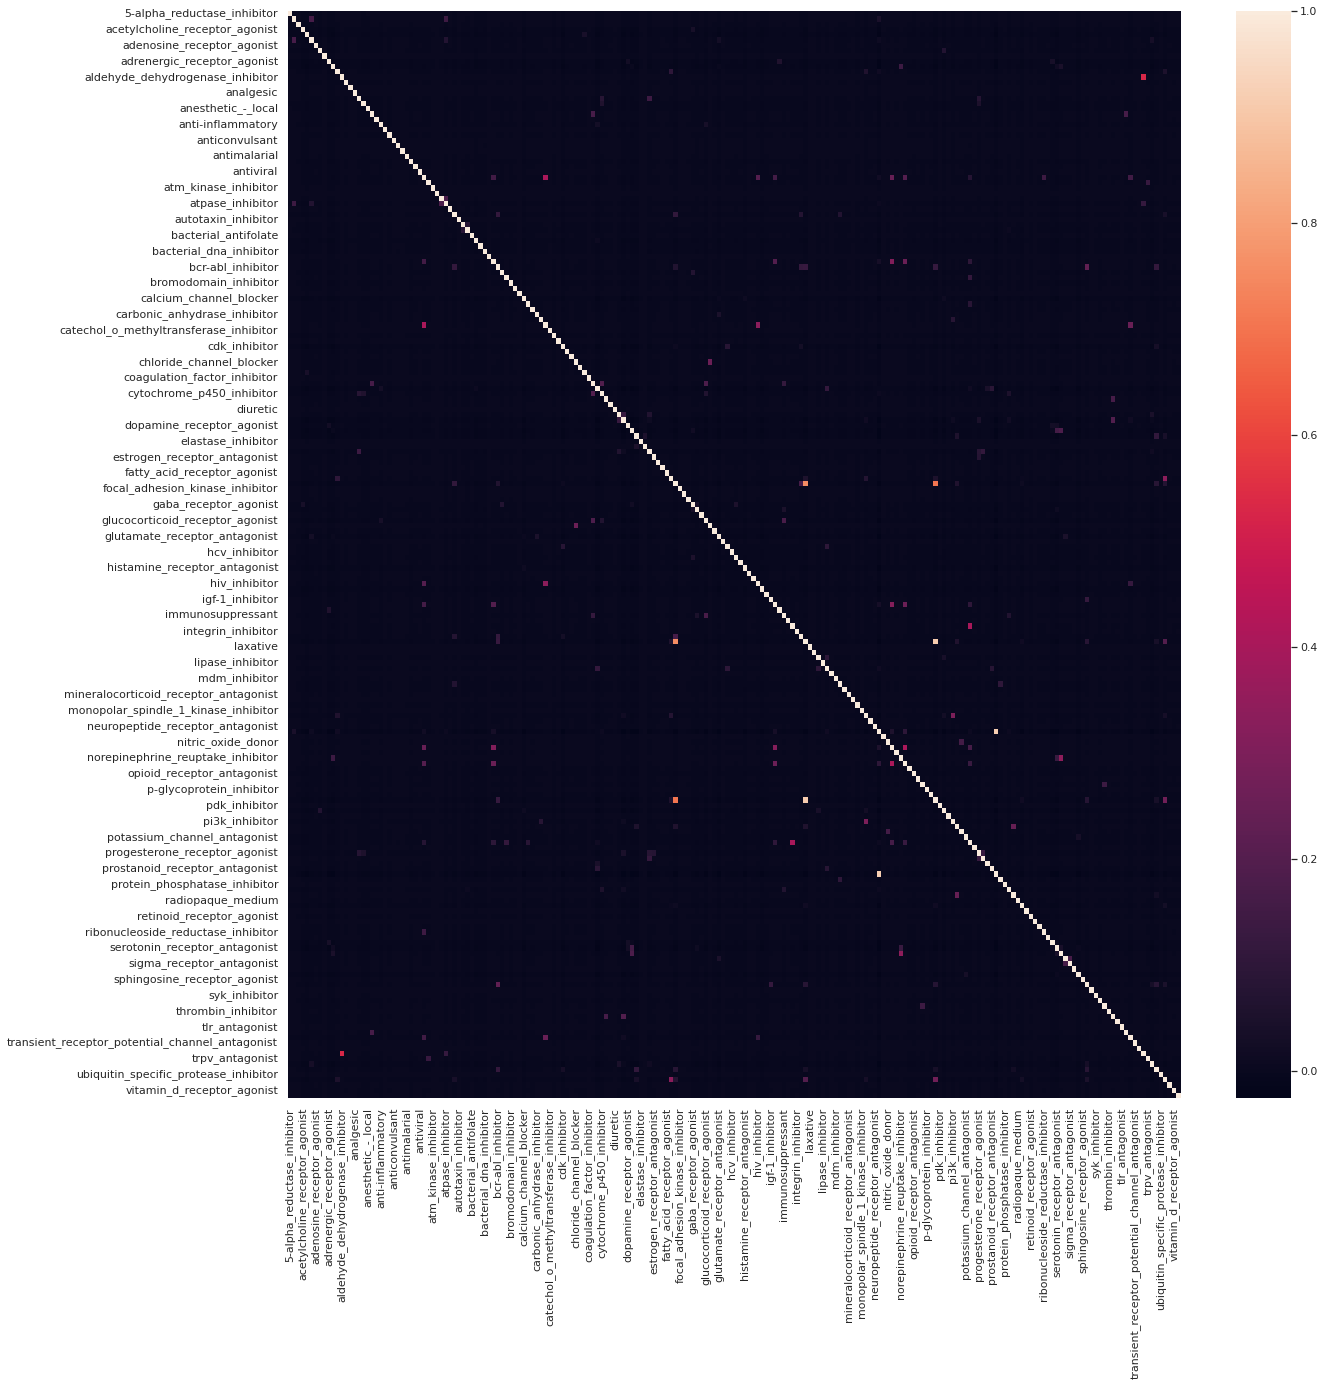

In [100]:
corr_matrix_targets_scored = train_targets_scored.corr()
fig = plt.figure(figsize=(20,20),alpha=0.75)
sns.heatmap(corr_matrix_targets_scored, fmt = '.2f')


In [101]:
correlated_pairs_targets = high_correlations(train_targets_scored, corr_matrix_targets_scored, threshold=0.8)
print(f'Number of highly correlated pairs in the target labels = {len(correlated_pairs_targets)}')

Pairs of highly correlated columns:
kit_inhibitor and pdgfr_inhibitor = 0.9156030237730939
nfkb_inhibitor and proteasome_inhibitor = 0.9213401736877982
Number of highly correlated pairs in the target labels = 2


# PRE-PROCESSING FEATURES

## 1. Scaling Gene and Cell Data

Comparing three scalers:

*   MinMaxScaler
*   StandardScaler
*   QuantileTransformer




In [102]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer

def compare_scalars(df):

  minmax_scaler = MinMaxScaler()
  standard_scaler = StandardScaler()
  quantile_transformer = QuantileTransformer(output_distribution='normal')

  df_minmax = pd.DataFrame(minmax_scaler.fit_transform(df), columns=df.columns)
  df_standard = pd.DataFrame(standard_scaler.fit_transform(df), columns=df.columns)
  df_quantile = pd.DataFrame(quantile_transformer.fit_transform(df), columns=df.columns)

  np.random.seed(42)
  random_columns = np.random.choice(df.columns, size=50, replace=False)

  def plot_kde(dataframe_list, column_list, method_names):
      num_columns_to_plot = len(column_list)
      num_methods = len(method_names)
      fig, axes = plt.subplots(num_columns_to_plot, num_methods, figsize=(24, 2 * num_columns_to_plot))
      
      for i, column in enumerate(column_list):
          for j, dataframe in enumerate(dataframe_list):
              sns.kdeplot(data=dataframe, x=column, ax=axes[i, j], fill=True, alpha=0.5, linewidth=1.5)
              axes[i, j].set_title(f'KDE of {column} ({method_names[j]})', fontsize=10)

      plt.subplots_adjust(hspace=0.8, wspace=0.5)
      plt.tight_layout()
      plt.show()

  plot_kde([df_minmax, df_standard, df_quantile], random_columns, ['MinMax', 'Standard', 'Quantile'])


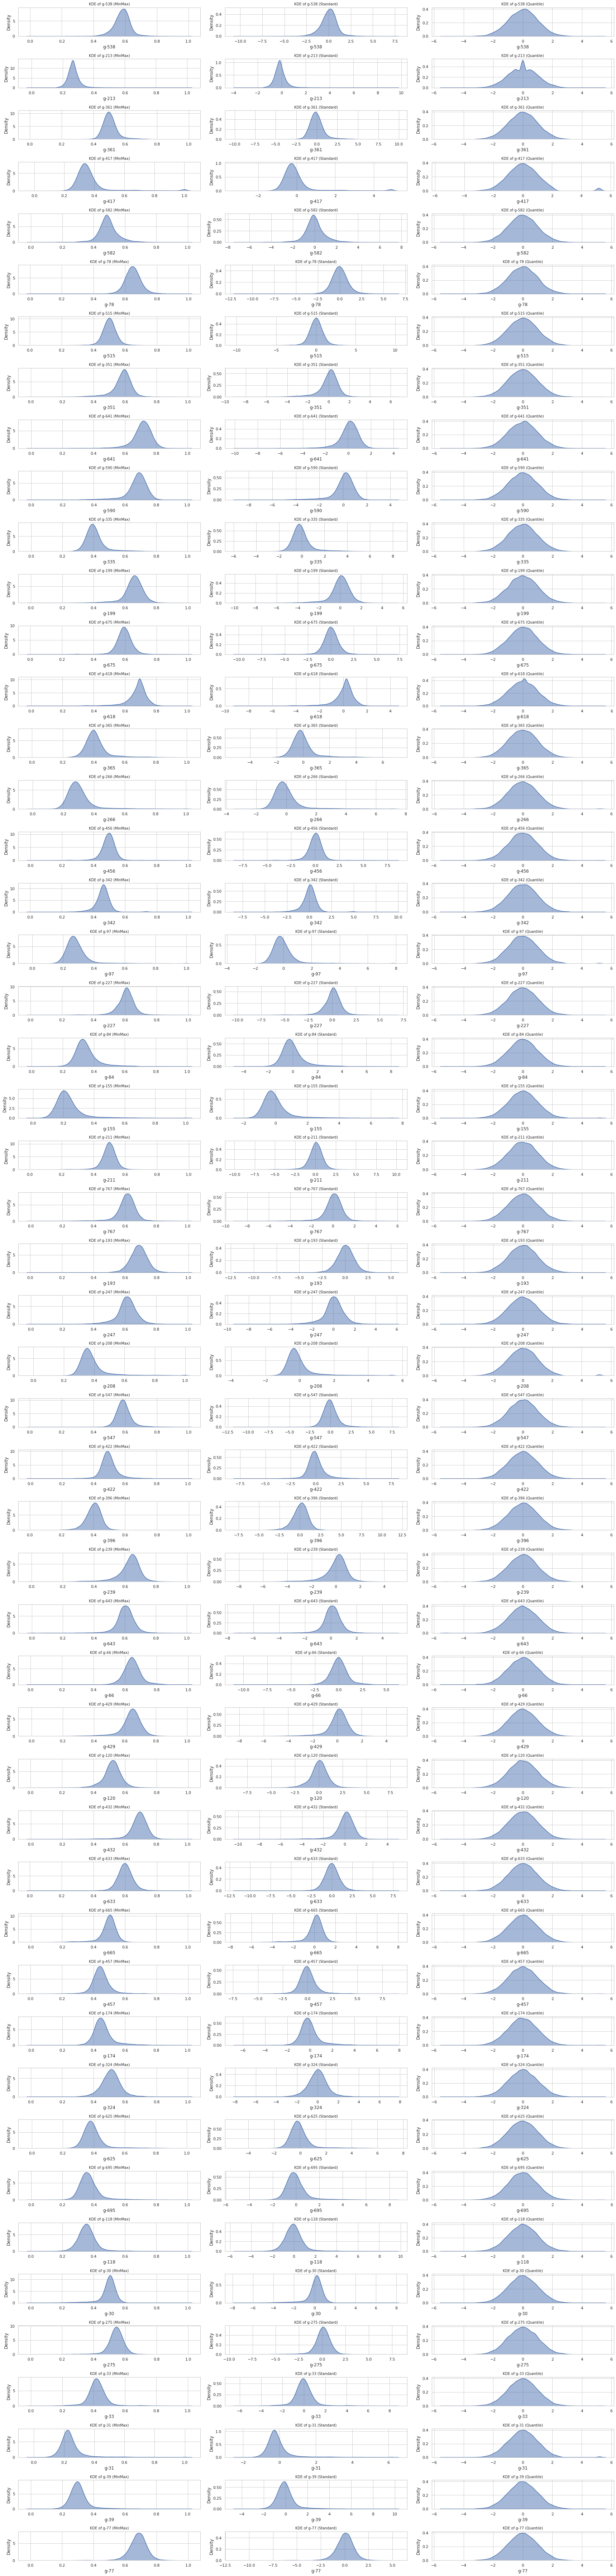

In [103]:
compare_scalars(GENE_DATA)

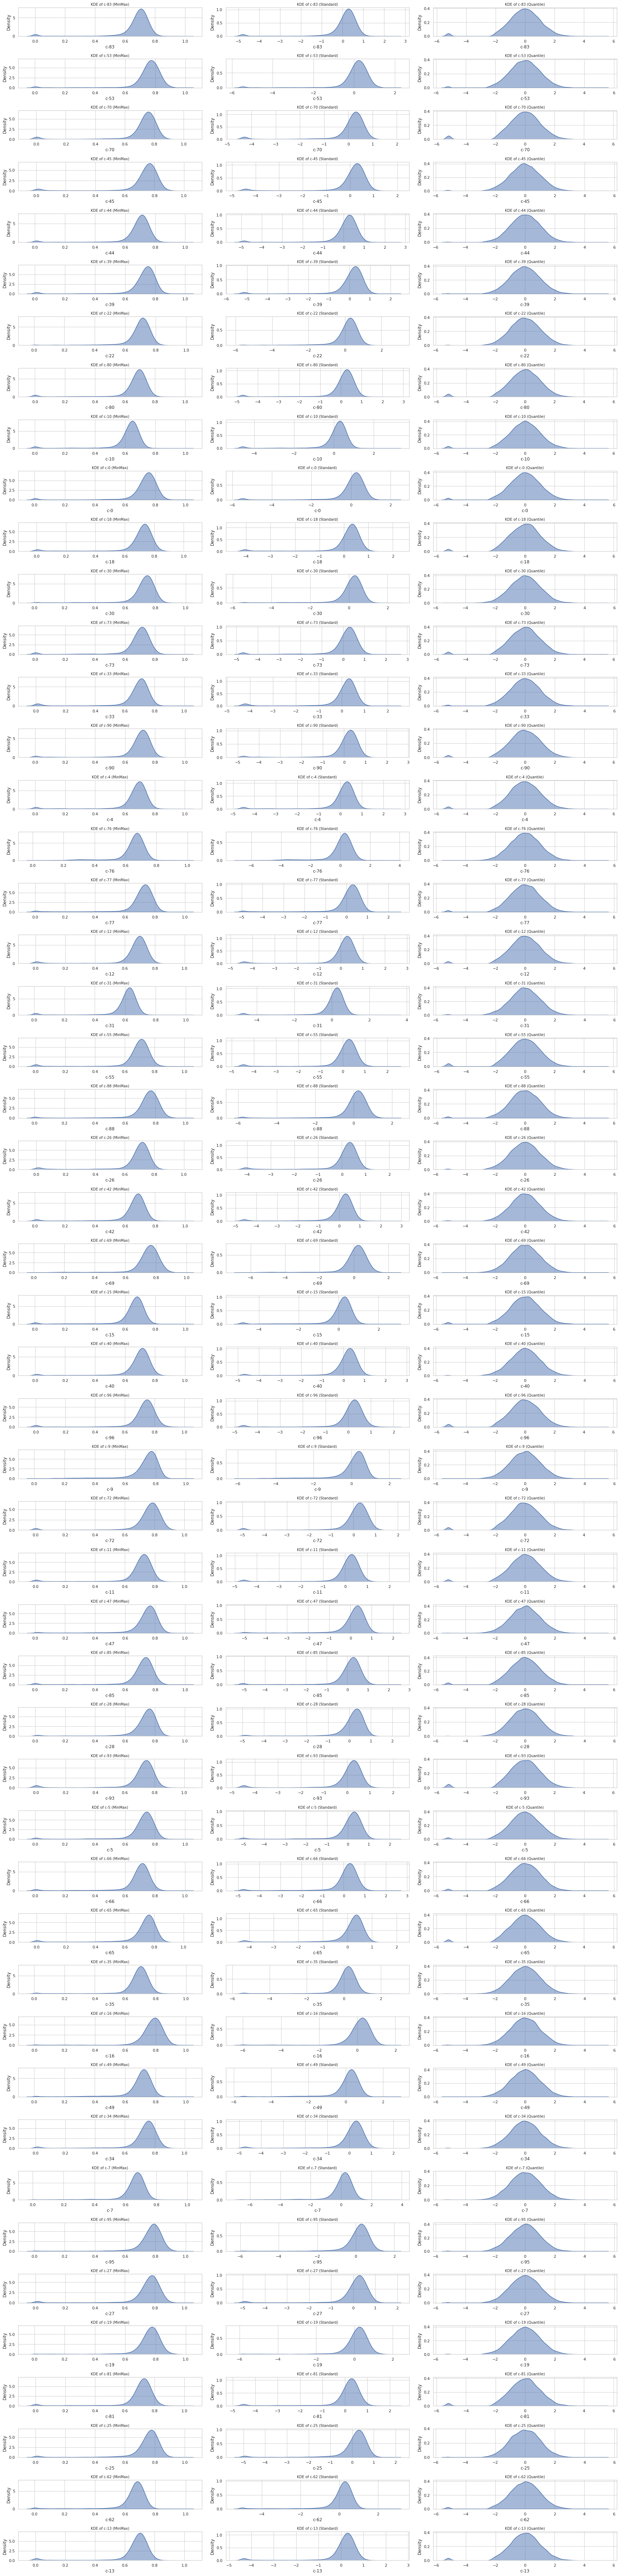

In [104]:
compare_scalars(CELL_DATA)

QunatileTransformer gives almost gaussian distribution centered around 0. Comparing different number of quantiles

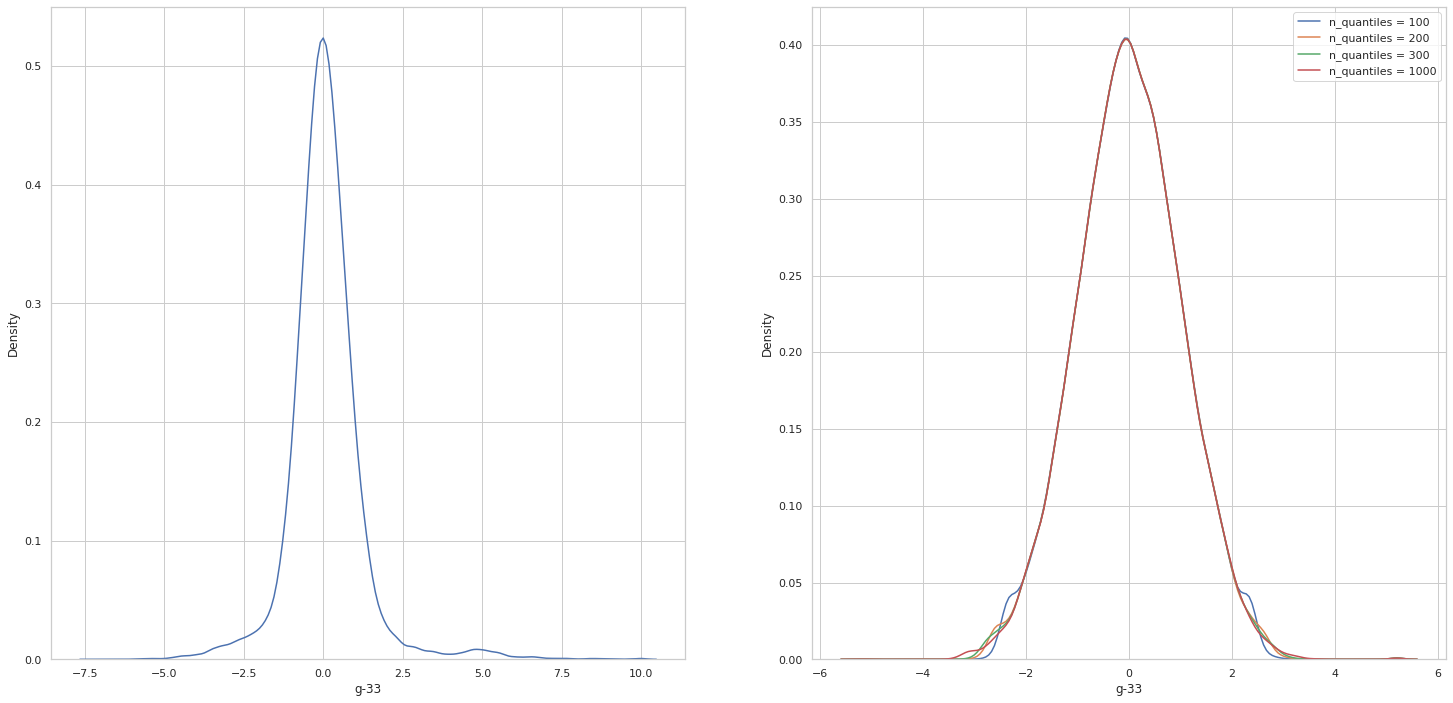

In [105]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(25,12))

sns.kdeplot(data=GENE_DATA['g-33'], ax=ax1, label=f'Sample Distribution')

for n in [100, 200, 300, 1000]:
  quantile_transformer = QuantileTransformer(n_quantiles=n, random_state=40, output_distribution='normal')
  GENE_DATA_scaled = pd.DataFrame(quantile_transformer.fit_transform(GENE_DATA), columns=GENE_DATA.columns)

  sns.kdeplot(data=GENE_DATA_scaled['g-33'], ax=ax2, label=f'n_quantiles = {n}')

plt.legend()
plt.show()


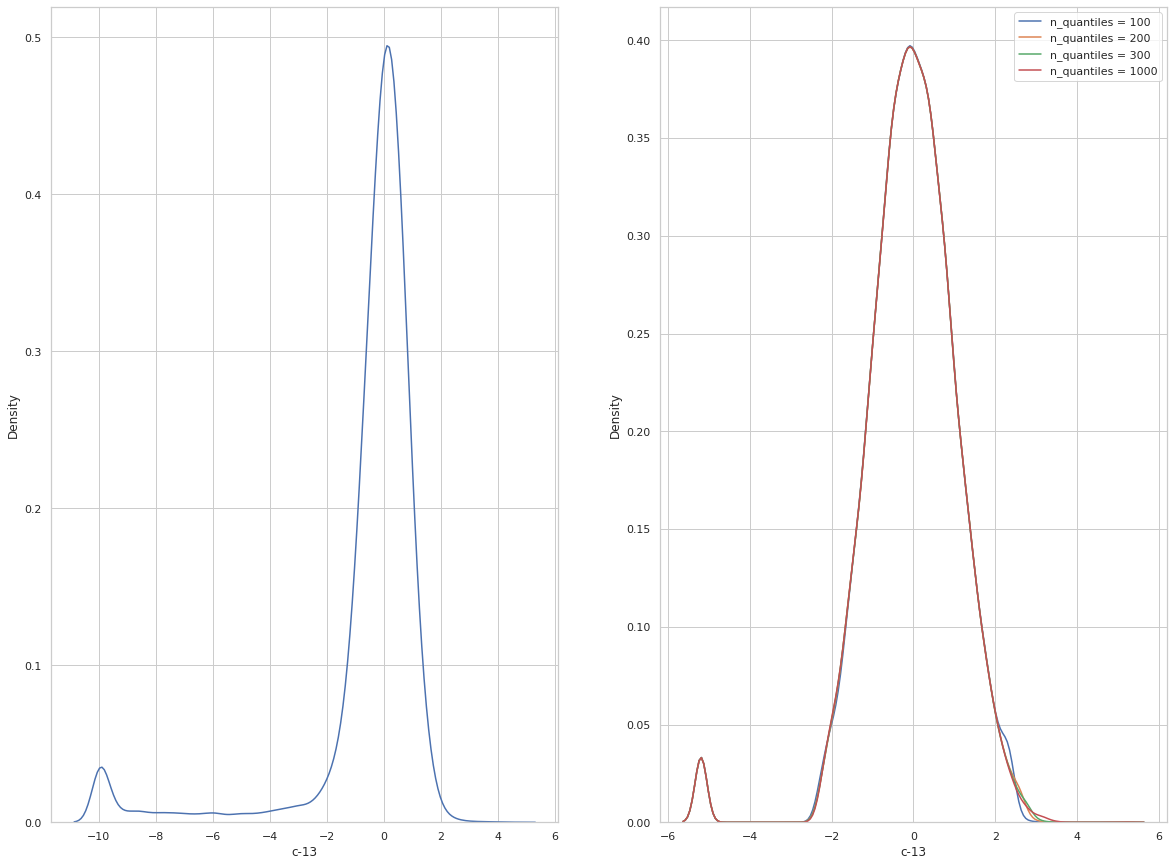

In [106]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,15))

sns.kdeplot(data=CELL_DATA['c-13'], ax=ax1, label=f'Sample Distribution')

for n in [100, 200, 300, 1000]:
  quantile_transformer = QuantileTransformer(n_quantiles=n, random_state=40, output_distribution='normal')
  CELL_DATA_scaled = pd.DataFrame(quantile_transformer.fit_transform(CELL_DATA), columns=CELL_DATA.columns)

  sns.kdeplot(data=CELL_DATA_scaled['c-13'], ax=ax2, label=f'n_quantiles = {n}')

plt.legend()
plt.show()


Using the default number of quantiles for the QuantileTransformer Scaler

In [109]:
quantile_transformer = QuantileTransformer(n_quantiles=1000, random_state=40, output_distribution='normal')
GENE_DATA_scaled = pd.DataFrame(quantile_transformer.fit_transform(GENE_DATA), columns=GENE_DATA.columns)
CELL_DATA_scaled = pd.DataFrame(quantile_transformer.fit_transform(CELL_DATA), columns=CELL_DATA.columns)

## Dimensionality Reduction using Principal Component Analysis

In [107]:
from sklearn.decomposition import PCA


In [108]:
def pca_analysis(df, feature, n_comp=100, plots=True):
  
  df = df.copy()
  X = df.value_counts
  pca = PCA(n_components=n_comp)
  pca_fit = pca.fit(df)
  X_pca = pca_fit.transform(df)

  evr = pca_fit.explained_variance_ratio_



  if plots:
    for i, ratio in enumerate(evr):
      # print(f'EVR for PC{i+1} = {ratio:.3f}')
    
      if i>0:

          print(f'EVR for {i+1}th component = {evr[i]} and difference = {abs(evr[i-1] - evr[i])}')

    print('Component Importance')
    labels = [f'{i+1}' for i in range(n_comp)]
    fig1, ax1 = plt.subplots(figsize=(30,15))
    ax1.bar(labels, evr)
    ax1.set_xlabel('Number of components')
    ax1.set_ylabel('Explained variance ratio')
    ax1.set_title(feature, fontsize=14)
    fig1.suptitle('Explained variance ratio', fontsize=20, fontweight="bold")
    plt.show()
    plt.close()

    print('Explained Variance Ratio')
    fig2, ax2 = plt.subplots(figsize=(14, 5))
    ax2.plot(np.cumsum(evr))
    ax2.set_xlabel('Number of components')
    ax2.set_ylabel('Cumulative explained variance')
    ax2.set_title(feature, fontsize=14)
    fig2.suptitle('Explained variance ratio', fontsize=20, fontweight="bold")
    plt.show()
    plt.close()

  return X_pca


### A. Gene Data

EVR for 2th component = 0.05104493761575428 and difference = 0.07275324134300992
EVR for 3th component = 0.04794621166874502 and difference = 0.0030987259470092593
EVR for 4th component = 0.033639336278735874 and difference = 0.014306875390009147
EVR for 5th component = 0.026948661528195725 and difference = 0.006690674750540148
EVR for 6th component = 0.021833901640956097 and difference = 0.005114759887239629
EVR for 7th component = 0.01819186688150966 and difference = 0.003642034759446435
EVR for 8th component = 0.016436842160494344 and difference = 0.0017550247210153178
EVR for 9th component = 0.01472444591622851 and difference = 0.001712396244265833
EVR for 10th component = 0.014273277444160558 and difference = 0.0004511684720679525
EVR for 11th component = 0.011003589523259728 and difference = 0.00326968792090083
EVR for 12th component = 0.010250720243846111 and difference = 0.000752869279413617
EVR for 13th component = 0.009554409810218073 and difference = 0.0006963104336280383
EV

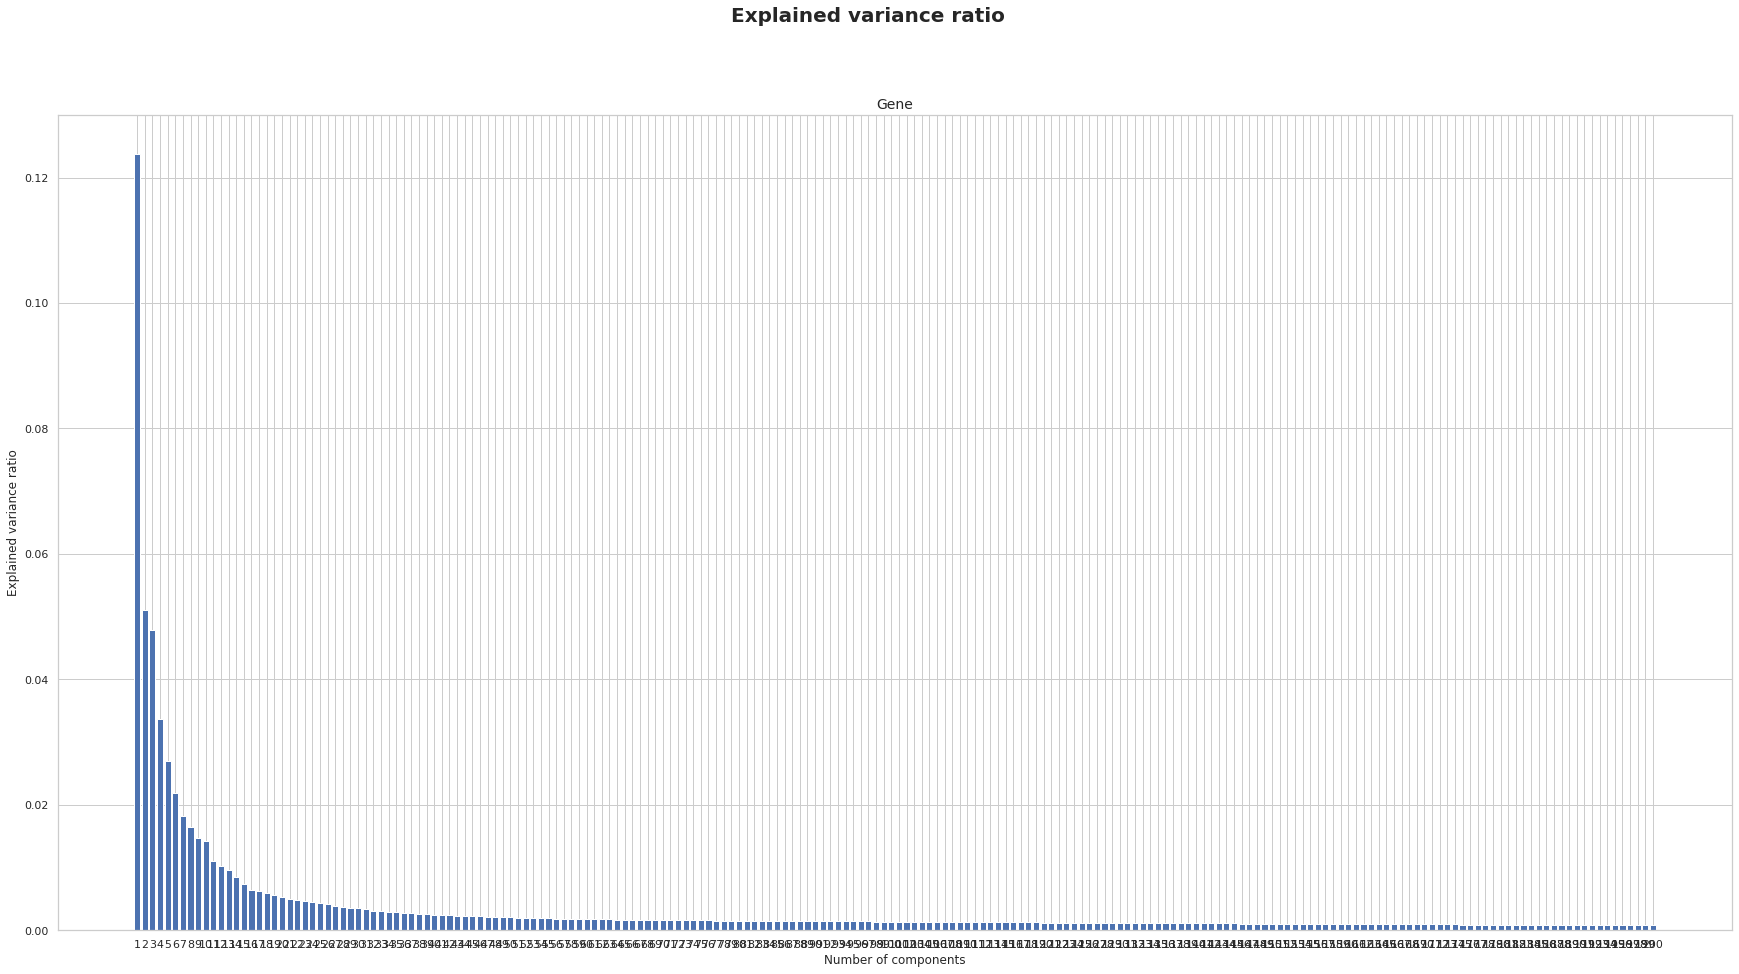

Explained Variance Ratio


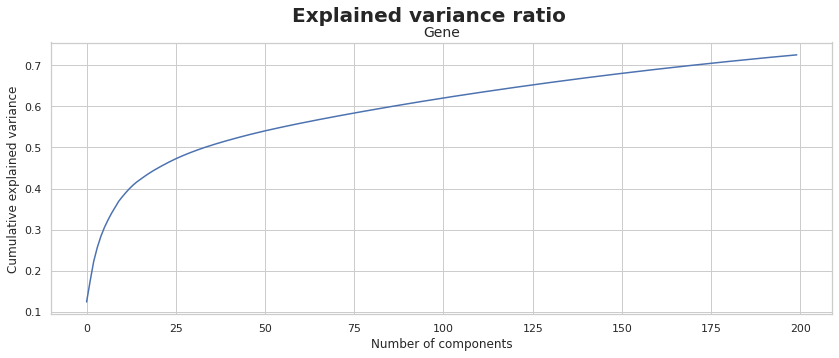

In [110]:
X_pca_gene = pca_analysis(GENE_DATA_scaled, 'Gene', n_comp=200)

### B. Cell Data

EVR for 2th component = 0.014727799841674605 and difference = 0.5016607413580091
EVR for 3th component = 0.010983912118372779 and difference = 0.003743887723301826
EVR for 4th component = 0.010497724979269088 and difference = 0.00048618713910369114
EVR for 5th component = 0.009349834876239738 and difference = 0.0011478901030293493
EVR for 6th component = 0.008634745575000602 and difference = 0.0007150893012391364
EVR for 7th component = 0.008206590301476073 and difference = 0.0004281552735245289
EVR for 8th component = 0.007504959956511071 and difference = 0.0007016303449650018
EVR for 9th component = 0.00718606437217383 and difference = 0.0003188955843372414
EVR for 10th component = 0.007105016720618517 and difference = 8.104765155531306e-05
EVR for 11th component = 0.006902846492114774 and difference = 0.00020217022850374262
EVR for 12th component = 0.006675503690314758 and difference = 0.0002273428018000163
EVR for 13th component = 0.006493944197909953 and difference = 0.00018155949

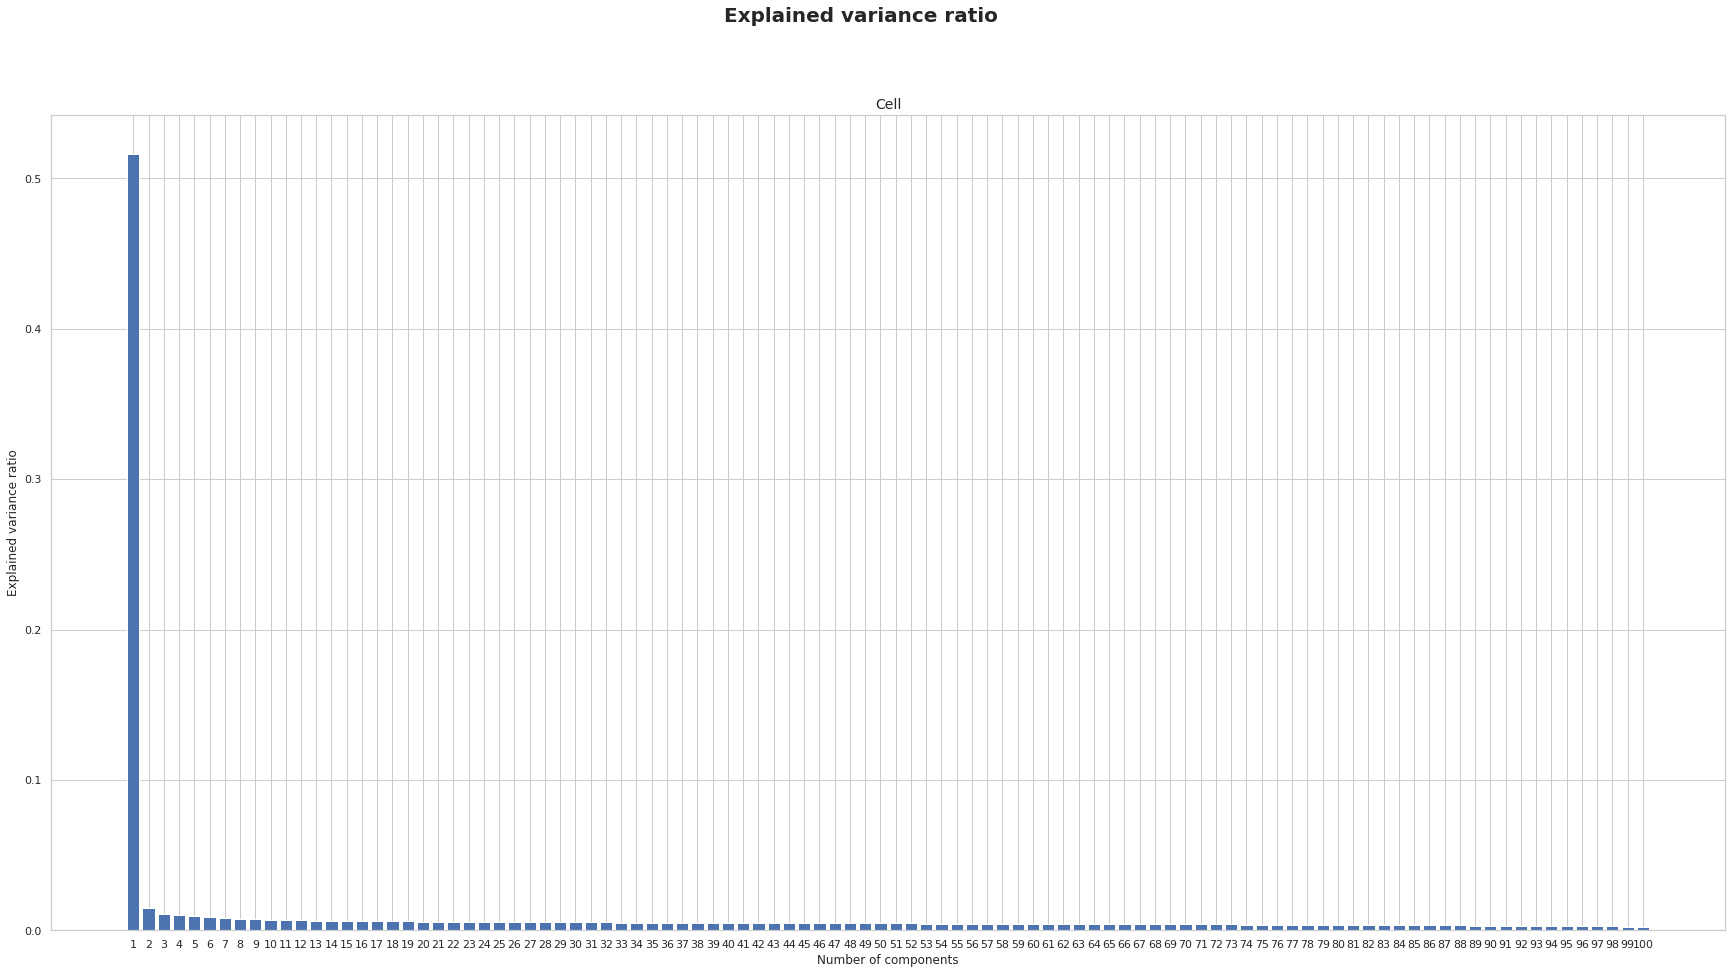

Explained Variance Ratio


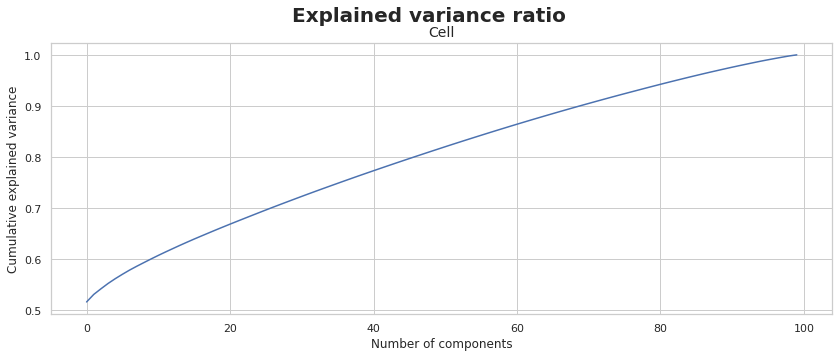

In [111]:
X_pca_cell = pca_analysis(CELL_DATA_scaled, 'Cell')

# MODEL FITTING

In [112]:
X_gene_pca = pd.DataFrame(pca_analysis(GENE_DATA_scaled, 'gene', n_comp=150, plots=False), columns=[f'PC{i+1}' for i in range(150)])
X_cell_pca = pd.DataFrame(pca_analysis(CELL_DATA_scaled, 'cell', n_comp=30, plots=False), columns=[f'PC{i+1}' for i in range(30)])

In [113]:
X_train = pd.concat([X_gene_pca, X_cell_pca, CP_DATA_encoded], axis=1).values
y = train_targets_scored.iloc[:, 1:].values


In [114]:
from sklearn.metrics import log_loss

def loss_metric(y_label, y_pred):
    metrics = []
    for t in range(y_label.shape[1]):
        metrics.append(log_loss(y_label[:, t], y_pred[:, t], labels=[0, 1]))
    return np.mean(metrics)


## XGBOOST

In [71]:
from sklearn.multiclass import OneVsRestClassifier
import xgboost
from xgboost import XGBClassifier


In [72]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score


Grid search using 5 fold cross validation.
This method takes long time to run

In [ ]:
# params = {
#     'estimator__tree_method': ['gpu_hist'],  # Use GPU accelerated algorithm
#     'estimator__gpu_id': [0],  # Set the GPU device ID (usually 0 for the first available GPU)
#     'estimator__max_depth': [4, 8, 12],
#     'estimator__min_child_weight': [10, 20, 30, 40],
#     'estimator__gamma': [1.5, 2.5, 3.5, 4.5],
#     'estimator__subsample': [0.5, 0.8, 1],
#     'estimator__reg_alpha': [0, 1, 2],
#     'estimator__reg_lambda': [1, 2, 3],
#     'estimator__learning_rate': [0.01, 0.1, 0.2],
#     'estimator__n_estimators': [100, 200, 300],
# }

# xgb = OneVsRestClassifier(XGBClassifier())

# grid_search = GridSearchCV(
#     xgb, params, scoring='f1_micro', cv=5,  refit=True
# )

# grid_search.fit(X_train, y)

# import pickle
# with open('xgboost_grid_search.pkl', 'wb') as file:
#     pickle.dump(grid_search, file)

# print("Best hyperparameters:", grid_search.best_params_)

# best_params = grid_search.best_params_
# best_params['estimator__early_stopping_rounds'] = 10

# xgb_best = OneVsRestClassifier(xgb.XGBClassifier(**best_params))


Base XGBoost model with default parameters

In [74]:
xgb = OneVsRestClassifier(XGBClassifier())

In [75]:
xgb.fit(X_train, y)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))

In [76]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

kfolds = MultilabelStratifiedKFold (n_splits=10, shuffle=True, random_state=42)

In [78]:
for fold, (train_idx, val_idx) in enumerate(kfolds.split(X_train, y)):
  print(f'FOLD = {fold+1}')

  X_val = X_train[val_idx]
  y_val = y[val_idx]

  y_pred = xgb.predict(X_val)
  print(loss_metric(y_val, y_pred))


FOLD = 1
7.348559059631889e-05
FOLD = 2
7.348559059631889e-05
FOLD = 3
2.2204460492503136e-16
FOLD = 4
2.2204460492503136e-16
FOLD = 5
2.2204460492503136e-16
FOLD = 6
2.2204460492503136e-16
FOLD = 7
2.2204460492503136e-16
FOLD = 8
2.2204460492503136e-16
FOLD = 9
2.2204460492503136e-16
FOLD = 10
2.2204460492503136e-16


The near zero loss metric indicates overfitting. Cross validation can be used to overcome this issue. 

In [79]:
with open('xg_boost.pkl', 'wb') as f:
  pickle.dump(xgb, f)

## Rklabel 

In [115]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble  import RandomForestClassifier
from skmultilearn.ensemble import RakelD


In [116]:
kfolds = MultilabelStratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [117]:
predictions = []
valditaions_sets = []

for fold, (train_idx, val_idx) in enumerate(kfolds.split(X_train, y)):
  print(f'FOLD = {fold+1}')


  X_training = X_train[train_idx]
  y_training = y[train_idx]
  X_validation = X_train[val_idx]
  y_validation = y[val_idx]

  classifier = RakelD(
      base_classifier=GaussianNB(),
      base_classifier_require_dense=[True, True],
      labelset_size=150
  )

  classifier.fit(X_training, y_training)
  oof_prediction = classifier.predict(X_validation)
  predictions.append(oof_prediction)
  valditaions_sets.append(y_validation)

  y_pred = oof_prediction.toarray()
  y_true = y_validation

  print(f'OOF loss metric for this fold:')
  print(loss_metric(y_true, y_pred))


FOLD = 1


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)


OOF loss metric for this fold:
0.2819852339145763
FOLD = 2


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)


OOF loss metric for this fold:
0.29299353343979373
FOLD = 3


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)


OOF loss metric for this fold:
0.29762277810935206


In [ ]:
import pickle
with open('RakelD_150_rf.pkl', 'wb') as file:
    pickle.dump(classifier, file)


with open('predictions_RakelD_150_rf.pkl', 'wb') as f:
    pickle.dump(predictions, f)

with open('valditaions_RakelD_150_rf.pkl', 'wb') as f:
    pickle.dump(valditaions_sets, f)



In [118]:
for y_true, y_pred in zip(valditaions_sets, predictions):
  y_pred = y_pred.toarray()
  print(loss_metric(y_true, y_pred))

0.2819852339145763
0.29299353343979373
0.29762277810935206


## Using Label Relations

The following code is taken from scikit-multilearn [user-guide](http://scikit.ml/labelrelations.html)

Although the labels themselves do no have large number of correlated pairs, the purpose of the following model was to test accuracy of this model

206 labels, 186 edges
{(47, 118): 13.0, (47, 148): 13.0, (118, 148): 261.0, (78, 92): 6.0, (135, 162): 718.0, (37, 47): 7.0, (37, 88): 19.0, (47, 88): 7.0, (37, 117): 7.0, (47, 117): 7.0, (88, 117): 27.0, (2, 92): 6.0, (70, 160): 6.0, (88, 118): 210.0, (88, 148): 204.0, (77, 176): 7.0, (70, 161): 18.0, (69, 95): 18.0, (69, 113): 6.0, (95, 113): 24.0, (65, 96): 6.0, (56, 98): 6.0, (15, 71): 6.0, (115, 156): 31.0, (79, 199): 18.0, (9, 98): 6.0, (132, 152): 42.0, (76, 193): 6.0, (76, 189): 24.0, (155, 181): 6.0, (0, 4): 6.0, (0, 35): 6.0, (4, 35): 6.0, (0, 135): 6.0, (4, 135): 6.0, (35, 135): 6.0, (126, 163): 6.0, (113, 165): 6.0, (78, 176): 71.0, (92, 93): 6.0, (93, 176): 6.0, (110, 183): 6.0, (75, 76): 18.0, (118, 201): 44.0, (148, 201): 62.0, (69, 71): 12.0, (71, 95): 12.0, (78, 177): 25.0, (11, 196): 7.0, (145, 187): 6.0, (20, 95): 6.0, (93, 113): 6.0, (76, 158): 12.0, (57, 152): 6.0, (178, 179): 6.0, (88, 199): 12.0, (82, 158): 12.0, (82, 159): 6.0, (158, 159): 6.0, (6, 150): 12.0, (

/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


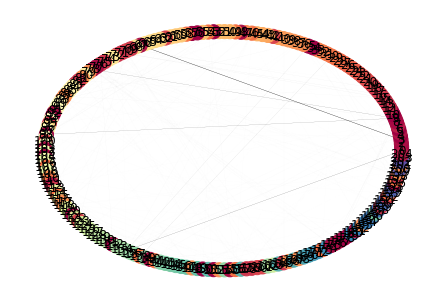

In [17]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder

graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
edge_map = graph_builder.transform(y)
print("{} labels, {} edges".format(len(train_targets_scored.columns), len(edge_map)))
print(edge_map)

from skmultilearn.cluster import NetworkXLabelGraphClusterer

def to_membership_vector(partition):
    return {
        member :  partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }


clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')

partition = clusterer.fit_predict(X_train,y)
partition.shape

membership_vector = to_membership_vector(partition)

import networkx as nx
names_dict = dict(enumerate(x[0].replace('-','-\n') for x in train_targets_scored.columns))

nx.draw(
    clusterer.graph_,
    pos=nx.circular_layout(clusterer.graph_),
    # labels=names_dict,
    with_labels = True,
    width = [10*x/y.shape[0] for x in clusterer.weights_['weight']],
    node_color = [membership_vector[i] for i in range(y.shape[1])],
    cmap=plt.cm.Spectral,
    node_size=200,
    font_size=12
)


In [18]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier
from skmultilearn.problem_transform import LabelPowerset


In [19]:
classifier = LabelSpacePartitioningClassifier(
    classifier = LabelPowerset(classifier=GaussianNB()),
    clusterer = clusterer
)


In [23]:
predictions=[]
valditaions_sets=[]

for fold, (train_idx, val_idx) in enumerate(kfolds.split(X_train, y)):
  print(f'\nFOLD = {fold+1}')

  X_training = X_train[train_idx]
  y_training = y[train_idx]
  X_validation = X_train[val_idx]
  y_validation = y[val_idx]


  classifier.fit(X_training, y_training)
  oof_prediction = classifier.predict(X_validation)
  predictions.append(oof_prediction)
  valditaions_sets.append(y_validation)

  y_pred = oof_prediction.toarray()
  y_true = y_validation

  print(f'OOF loss metric for this fold:')
  print(loss_metric(y_true, y_pred))


FOLD = 0
(22624, 184)
(22624, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.3711215554458178
FOLD = 1
(22623, 184)
(22623, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.4183916846373723
FOLD = 2
(22624, 184)
(22624, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.3876695742184397
FOLD = 3
(22623, 184)
(22623, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.4327114175068378
FOLD = 4
(22623, 184)
(22623, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.4919094884414326
FOLD = 5
(22623, 184)
(22623, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.423263346335232
FOLD = 6
(22623, 184)
(22623, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.3422166108162978
FOLD = 7
(22624, 184)
(22624, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.2990194736508223
FOLD = 8
(22623, 184)
(22623, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.4118961357068933
FOLD = 9
(22623, 184)
(22623, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.4526409426344444
FOLD = 10
(22623, 184)
(22623, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.450278924841543
FOLD = 11
(22623, 184)
(22623, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.3129866406291413
FOLD = 12
(22624, 184)
(22624, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.343196773767018
FOLD = 13
(22623, 184)
(22623, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.390933227794892
FOLD = 14
(22623, 184)
(22623, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.3752848599169192
FOLD = 15
(22623, 184)
(22623, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.4409784797819933
FOLD = 16
(22624, 184)
(22624, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.4087978481870551
FOLD = 17
(22624, 184)
(22624, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.3644727979032463
FOLD = 18
(22623, 184)
(22623, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.4417166103422747
FOLD = 19
(22623, 184)
(22623, 205)


/usr/local/lib/python3.9/dist-packages/skmultilearn/cluster/networkx.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


1.385323435536751


In [62]:
with open('Label_Classifier.pkl', 'wb') as f:
  pickle.dump(classifier, f)

with open('predictions_Label_Classifier_rf.pkl', 'wb') as f:
    pickle.dump(predictions, f)

with open('valditaions_Label_Classifier_rf.pkl', 'wb') as f:
    pickle.dump(valditaions_sets, f)



In [63]:
for y_true, y_pred in zip(valditaions_sets, predictions):
  y_pred = y_pred.toarray()
  print(loss_metric(y_true, y_pred))

1.3711215554458178
1.4183916846373723
1.3876695742184397
1.4327114175068378
1.4919094884414326
1.423263346335232
1.3422166108162978
1.2990194736508223
1.4118961357068933
1.4526409426344444
1.450278924841543
1.3129866406291413
1.343196773767018
1.390933227794892
1.3752848599169192
1.4409784797819933
1.4087978481870551
1.3644727979032463
1.4417166103422747
1.385323435536751


Other Models tested but did not work very well

1. Support Vector Classifier

In [ ]:
from sklearn.svm import SVC


In [ ]:
import warnings
warnings.simplefilter("ignore")

svc_clf = OneVsRestClassifier(SVC(probability=True))
svc_clf.fit(X_train, y)


2. Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier(n_estimators=200,max_depth=10, random_state=0,min_samples_split=10)
model.fit(X_train, y) 


# NEURAL NETWORK IMPLEMENTATION

In [51]:
train_features = pd.read_csv(out_dir + '/train_features.csv')
train_targets_scored = pd.read_csv(out_dir + '/train_targets_scored.csv')

In [53]:
train_features = train_features.drop('sig_id', axis=1)
train_labels = train_targets_scored.drop('sig_id', axis=1)

In [52]:
def preprocess(df):
    df = df.copy()
    df.drop(['cp_type'], axis=1, inplace=True)
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    df.loc[:, 'cp_time'] = df.loc[:, 'cp_time'].map({24: 0, 48: 1, 72: 2})    
    df = pd.get_dummies(df, columns=['cp_time','cp_dose'])
    return df

In [54]:
train_features = preprocess(train_features)


In [24]:
import tensorflow as tf

def nn_model(input_dim):

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1024, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(206, activation='softmax')
        ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [45]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

kfolds = MultilabelStratifiedKFold (n_splits=3, shuffle=True, random_state=42)

In [56]:
val_accs = []
histories = dict()
models = dict()
metrics = []

for fold, (train_idx, val_idx) in enumerate(kfolds.split(train_features.values, train_labels)):

  n_fold = fold + 1
  print(f'\nFOLD {n_fold}')

  X_train = train_features.values[train_idx]
  y_train = train_labels.values[train_idx]
  X_val = train_features.values[val_idx]
  y_val = train_labels.values[val_idx]

  mod = nn_model(X_train.shape[1])

  history = mod.fit(X_train, y_train, 
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    verbose=2
                    )

  val_loss, val_acc = mod.evaluate(X_val, y_val)
  val_accs.append(val_acc)

  metrics.append( loss_metric(y_val, 
                  mod.predict(X_val,batch_size=128))
  )

  histories[f'history_fold_{n_fold}'] = history
  models[f'model_fold_{n_fold}'] = mod


print(metrics)


FOLD 1
Epoch 1/50
125/125 - 17s - loss: 0.8000 - accuracy: 0.0152 - val_loss: 0.6832 - val_accuracy: 0.0315 - 17s/epoch - 135ms/step
Epoch 2/50
125/125 - 9s - loss: 0.6926 - accuracy: 0.0239 - val_loss: 0.6084 - val_accuracy: 0.0309 - 9s/epoch - 70ms/step
Epoch 3/50
125/125 - 10s - loss: 0.5723 - accuracy: 0.0274 - val_loss: 0.4580 - val_accuracy: 0.0353 - 10s/epoch - 81ms/step
Epoch 4/50
125/125 - 10s - loss: 0.3963 - accuracy: 0.0308 - val_loss: 0.2864 - val_accuracy: 0.0474 - 10s/epoch - 82ms/step
Epoch 5/50
125/125 - 11s - loss: 0.2404 - accuracy: 0.0349 - val_loss: 0.1668 - val_accuracy: 0.0650 - 11s/epoch - 89ms/step
Epoch 6/50
125/125 - 9s - loss: 0.1435 - accuracy: 0.0385 - val_loss: 0.1022 - val_accuracy: 0.0663 - 9s/epoch - 71ms/step
Epoch 7/50
125/125 - 10s - loss: 0.0919 - accuracy: 0.0446 - val_loss: 0.0693 - val_accuracy: 0.0674 - 10s/epoch - 81ms/step
Epoch 8/50
125/125 - 10s - loss: 0.0656 - accuracy: 0.0486 - val_loss: 0.0528 - val_accuracy: 0.0692 - 10s/epoch - 82ms/

In [58]:
import pickle

with open('nn_implementation.pkl', 'wb') as f:
  pickle.dump(mod, f)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......batch_normalization_2
.........vars
............0
............1
............2
............3
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.

In [59]:
metrics

[0.01687906077311625, 0.016863779649356096, 0.017242963612270706]

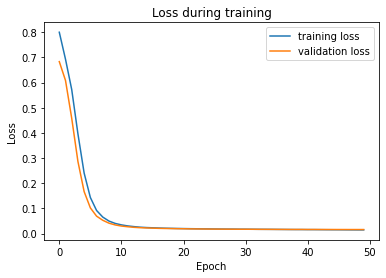

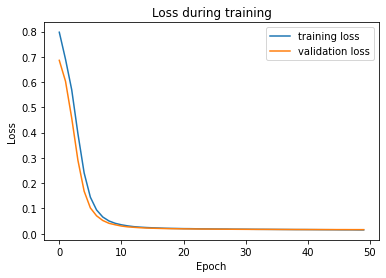

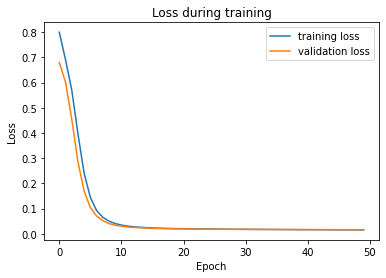

In [60]:
for key, history in histories.items():
  plt.plot(history.history['loss'], label='training loss')
  plt.plot(history.history['val_loss'], label='validation loss')
  plt.title('Loss during training')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  plt.close()
